FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Dataset Shape: (2500, 6)
Columns: ['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure', 'Rain']

First 10 rows:
   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain
5    26.147353  48.217260   15.258547    59.766279  1049.738751  no rain
6    20.939680  40.799444    2.232566    45.827508  1014.173766  no rain
7    32.294325  51.848471    2.873621    92.551497  1006.041733  no rain
8    34.091569  48.057114    5.570206    82.524873   993.732047  no rain
9    19.586038  82.978293   

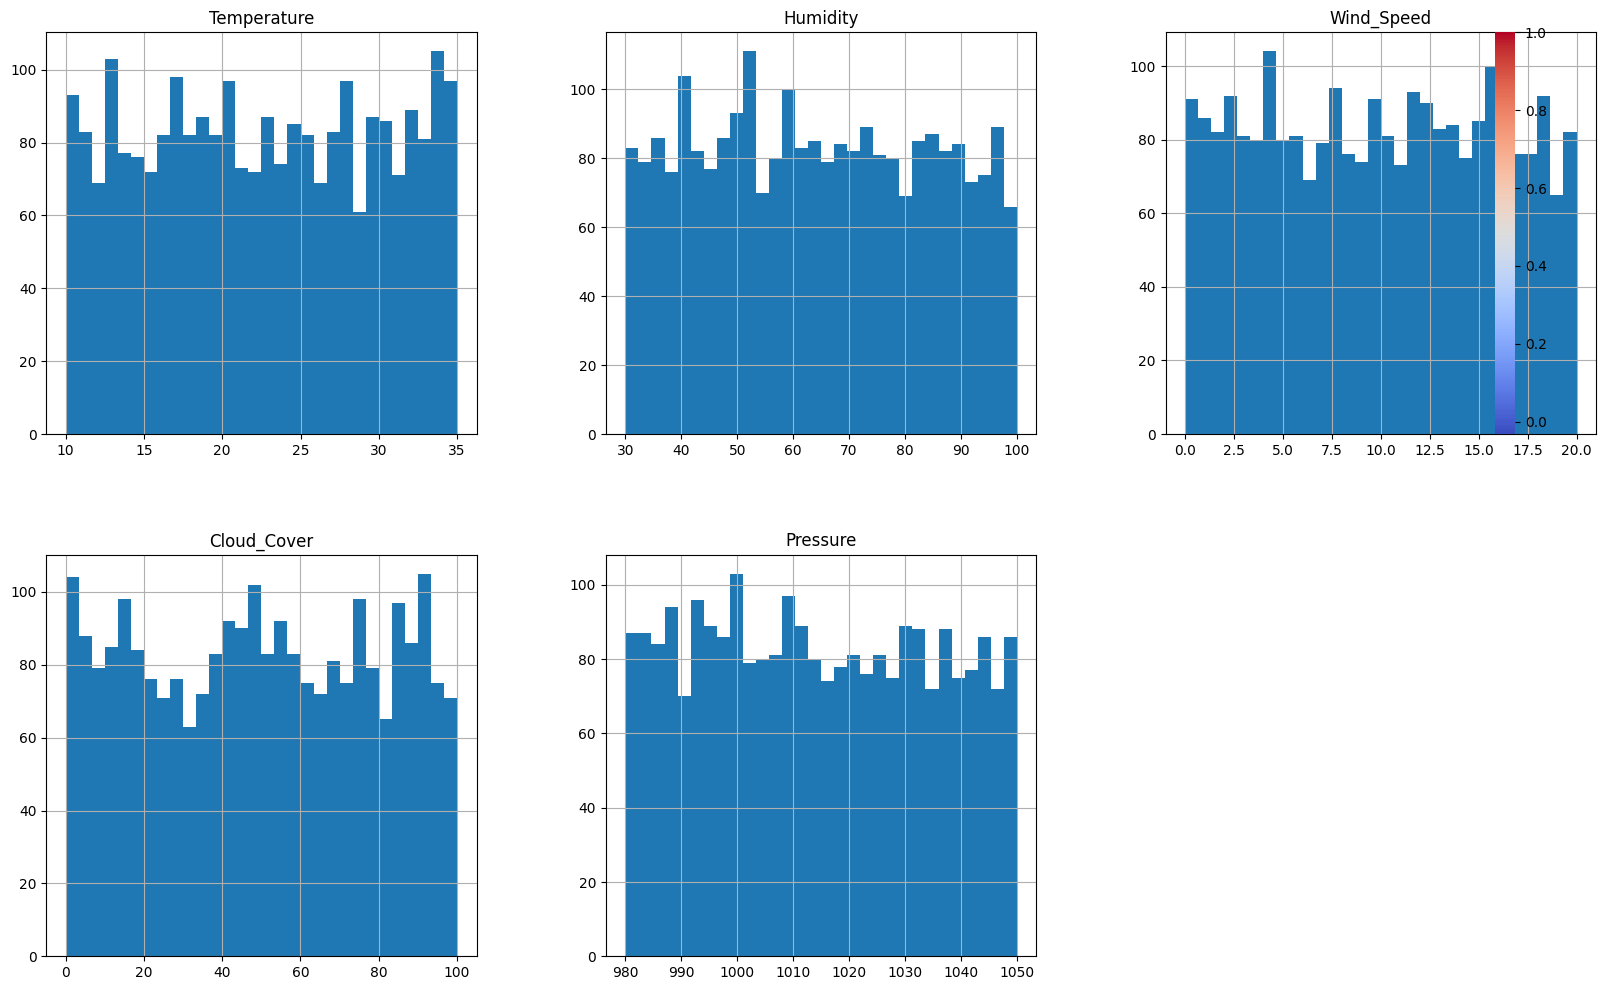


Encoded Rain: 2 classes

Final feature columns: ['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure', 'Rain']

Scaled data shape: (2500, 6)

Scaled data sample:
   Temperature  Humidity  Wind_Speed  Cloud_Cover  Pressure      Rain
0     0.155431  1.265393   -0.444814     0.028972  0.894714  2.638519
1     0.723225 -0.895074   -0.684143    -1.534074 -1.074570 -0.379000
2     0.339547  0.938599   -1.476731    -1.195246 -0.350663 -0.379000
3     0.142018  0.502270   -0.494138     0.604355 -1.568924  2.638519
4    -0.271701  1.629599   -0.910571    -0.068058 -1.658406 -0.379000

Sequences shape: (2476, 24, 6)
Targets shape: (2476, 6)

Train: (1584, 24, 6), Val: (396, 24, 6), Test: (496, 24, 6)

Standard LSTM parameters: 18276
Fractal LSTM parameters: 9246

Training Standard LSTM...
Epoch 10/50 - Train Loss: 0.993626, Val Loss: 0.980548
Epoch 20/50 - Train Loss: 0.937447, Val Loss: 1.029877
Epoch 30/50 - Train Loss: 0.796278, Val Loss: 1.280455
Epoch 40/50 - Train Loss: 0.64

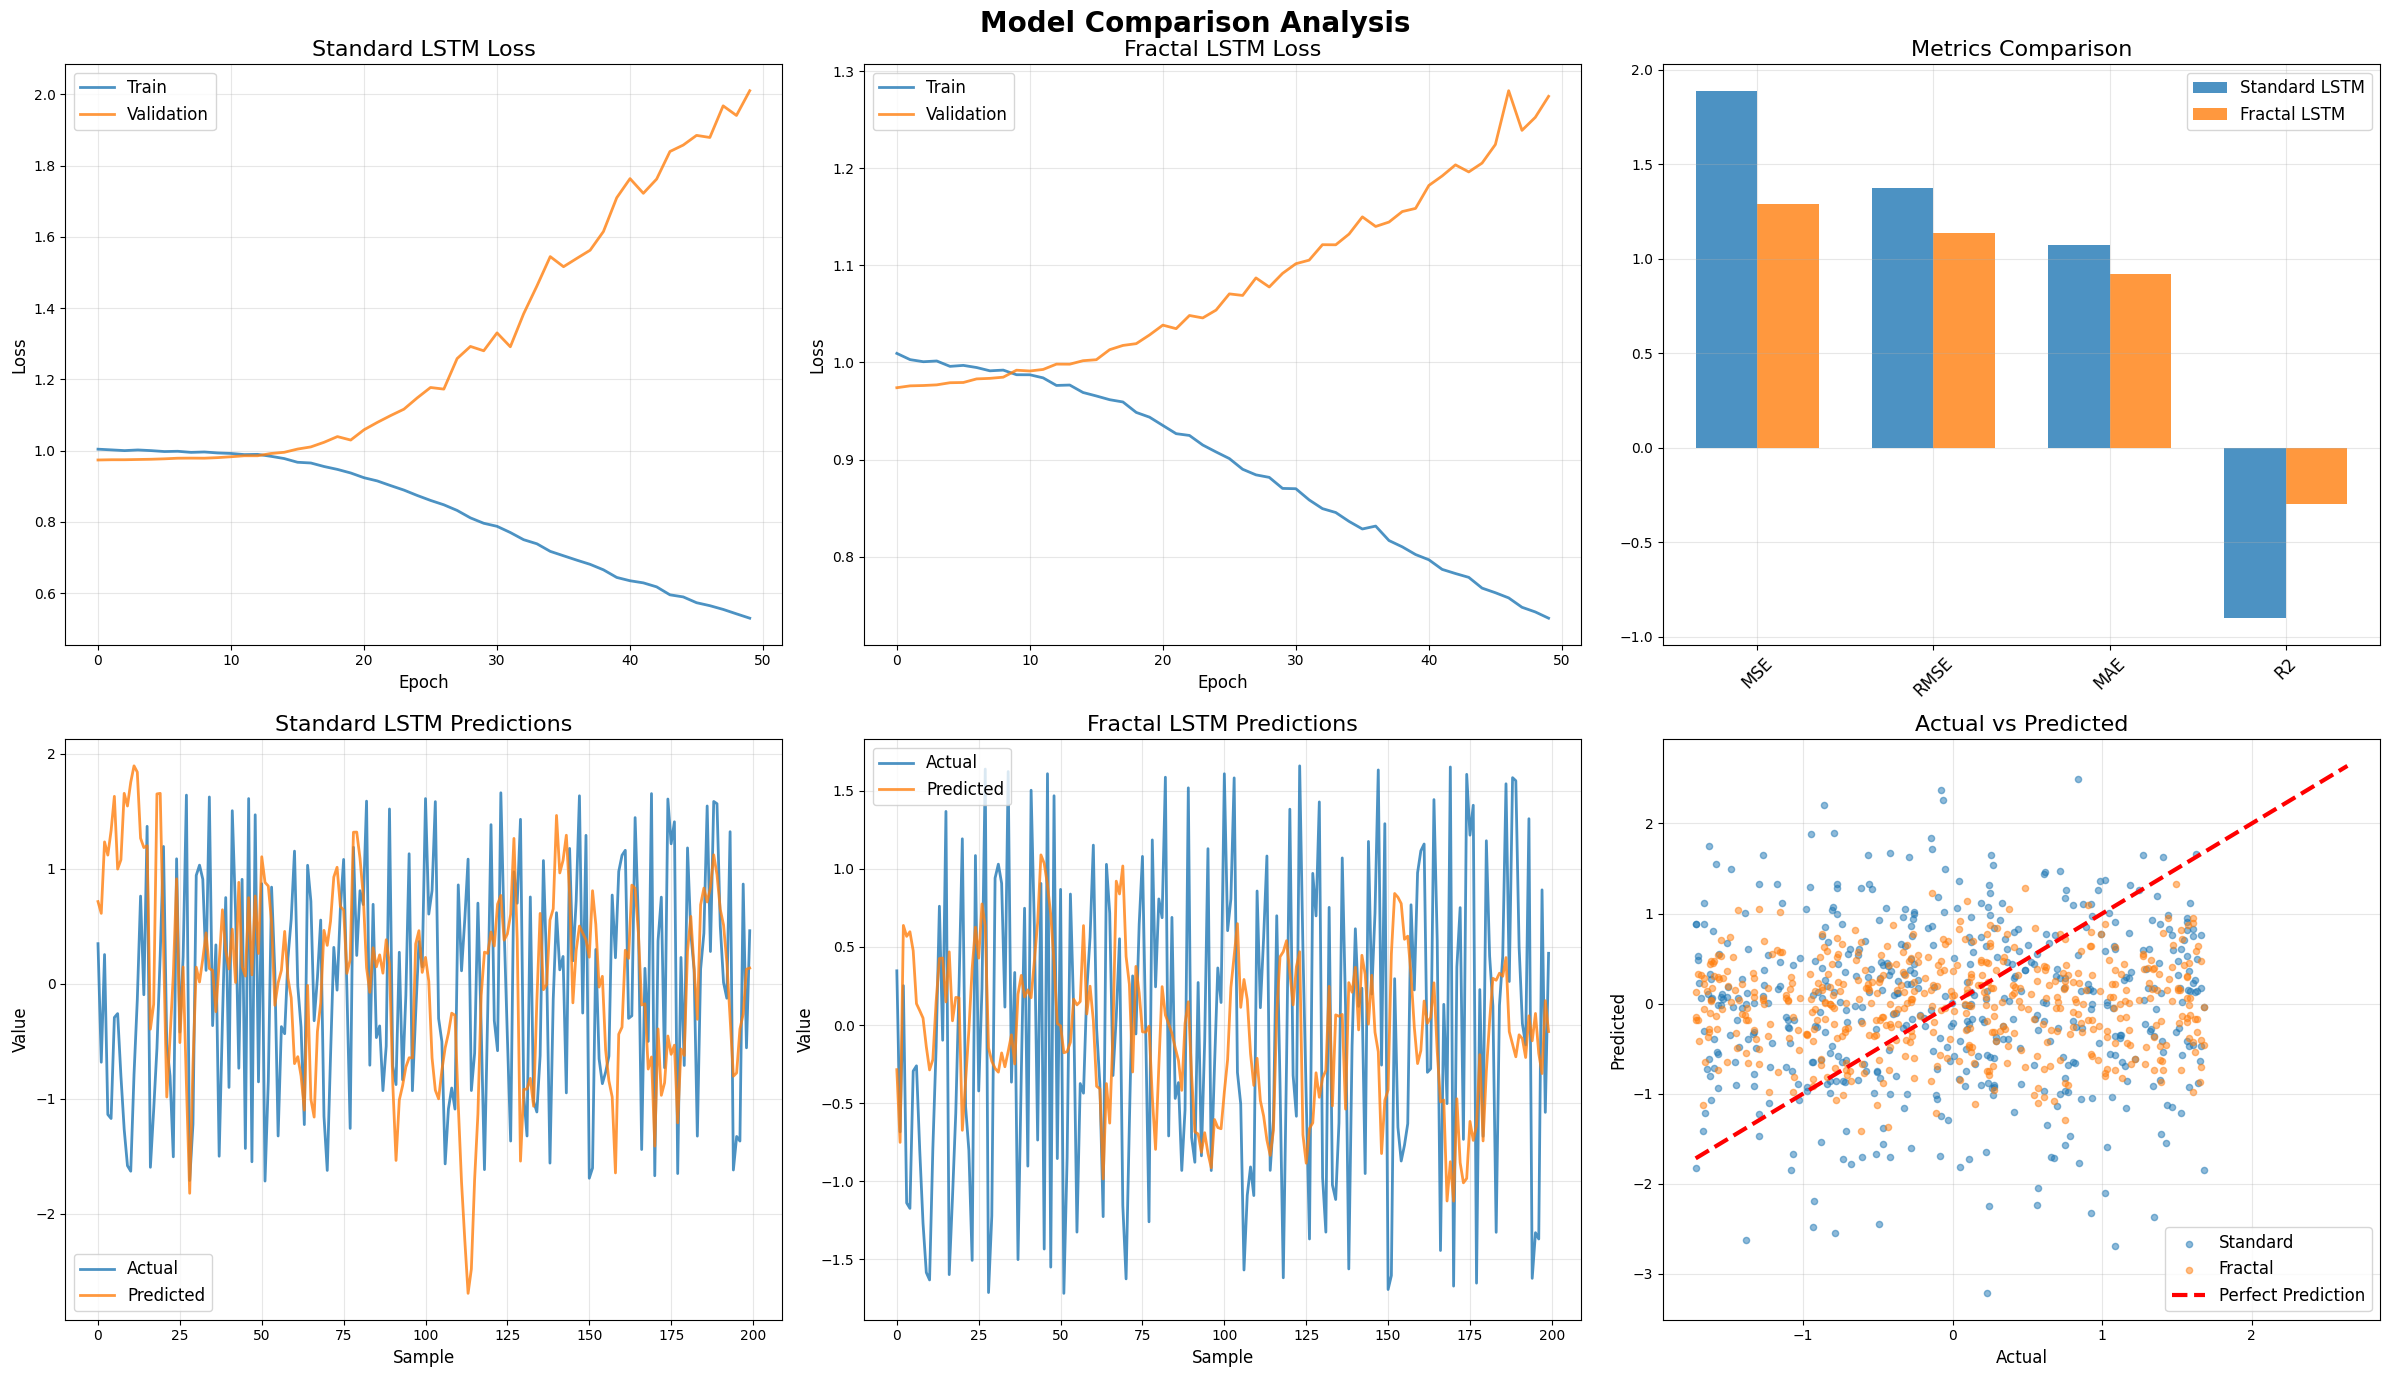


Analysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'

GPU Memory Used: 0.03 GB


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '/kaggle/input/weather-forecast-dataset/weather_forecast_data.csv'
SEQUENCE_LENGTH = 24
HIDDEN_SIZE = 63
FRACTAL_LEVELS = 3
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK")
print("="*80)
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

df = pd.read_csv(FILE_PATH)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Dataset Analysis', fontsize=20, fontweight='bold')

if len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=30, ax=axes[0,0], layout=(len(numeric_cols)//3+1, 3))
    axes[0,0].set_title('Distributions', fontsize=14)
    
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0,1], fmt='.2f', annot_kws={'size': 10})
axes[0,1].set_title('Correlation Matrix', fontsize=14)

if len(numeric_cols) >= 2:
    axes[1,0].plot(df[numeric_cols[0]].values[:200], linewidth=2)
    axes[1,0].set_title(f'{numeric_cols[0]} Time Series (First 200)', fontsize=14)
    axes[1,0].set_xlabel('Time', fontsize=12)
    axes[1,0].set_ylabel('Value', fontsize=12)
    axes[1,0].grid(True, alpha=0.3)

if len(df) > 0:
    axes[1,1].boxplot([df[col].dropna() for col in numeric_cols[:5]], labels=numeric_cols[:5])
    axes[1,1].set_title('Boxplots', fontsize=14)
    axes[1,1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1,1].tick_params(axis='y', labelsize=10)
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

df_processed = df.copy()

for col in categorical_cols:
    if df_processed[col].nunique() < 50:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        print(f"\nEncoded {col}: {df_processed[col].nunique()} classes")

df_processed = df_processed.fillna(df_processed.mean())

feature_cols = [col for col in df_processed.columns if col in numeric_cols or col in categorical_cols]
print(f"\nFinal feature columns: {feature_cols}")

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed[feature_cols]),
    columns=feature_cols
)

print(f"\nScaled data shape: {df_scaled.shape}")
print("\nScaled data sample:")
print(df_scaled.head())

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

data_array = df_scaled.values
X, y = create_sequences(data_array, SEQUENCE_LENGTH)

print(f"\nSequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class FractalMemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_levels):
        super(FractalMemoryCell, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.level_size = hidden_size // num_levels
        
        self.input_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.forget_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.cell_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.output_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        
        self.level_interactions = nn.ModuleList([
            nn.Linear((hidden_size // num_levels) * 2, hidden_size // num_levels) 
            for _ in range(num_levels - 1)
        ])
    
    def forward(self, x, hidden_states, cell_states):
        new_hidden_states = []
        new_cell_states = []
        level_size = self.hidden_size // self.num_levels
        
        for level in range(self.num_levels):
            h_prev = hidden_states[level]
            c_prev = cell_states[level]
            
            combined = torch.cat([x, h_prev], dim=1)
            
            i_t = torch.sigmoid(self.input_gates[level](combined))
            f_t = torch.sigmoid(self.forget_gates[level](combined))
            c_tilde = torch.tanh(self.cell_gates[level](combined))
            o_t = torch.sigmoid(self.output_gates[level](combined))
            
            c_t = f_t * c_prev + i_t * c_tilde
            
            if level > 0:
                interaction = torch.cat([c_t, new_cell_states[level-1]], dim=1)
                c_t = c_t + torch.tanh(self.level_interactions[level-1](interaction))
            
            h_t = o_t * torch.tanh(c_t)
            
            new_hidden_states.append(h_t)
            new_cell_states.append(c_t)
        
        return new_hidden_states, new_cell_states

class FractalMemoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_levels):
        super(FractalMemoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        
        self.fractal_cell = FractalMemoryCell(input_size, hidden_size, num_levels)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        level_size = self.hidden_size // self.num_levels
        
        hidden_states = [torch.zeros(batch_size, level_size, device=x.device) 
                        for _ in range(self.num_levels)]
        cell_states = [torch.zeros(batch_size, level_size, device=x.device) 
                      for _ in range(self.num_levels)]
        
        for t in range(seq_len):
            hidden_states, cell_states = self.fractal_cell(
                x[:, t, :], hidden_states, cell_states
            )
        
        final_hidden = torch.cat(hidden_states, dim=1)
        out = self.fc(final_hidden)
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

standard_lstm = StandardLSTM(input_size, HIDDEN_SIZE, output_size).to(device)
fractal_lstm = FractalMemoryLSTM(input_size, HIDDEN_SIZE, output_size, FRACTAL_LEVELS).to(device)

print(f"\nStandard LSTM parameters: {sum(p.numel() for p in standard_lstm.parameters())}")
print(f"Fractal LSTM parameters: {sum(p.numel() for p in fractal_lstm.parameters())}")

def train_model(model, train_loader, val_loader, epochs, lr, model_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    print(f"\nTraining {model_name}...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return predictions, actuals, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

standard_train_losses, standard_val_losses = train_model(
    standard_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Standard LSTM"
)

fractal_train_losses, fractal_val_losses = train_model(
    fractal_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Fractal Memory LSTM"
)

standard_preds, standard_actuals, standard_metrics = evaluate_model(standard_lstm, test_loader)
fractal_preds, fractal_actuals, fractal_metrics = evaluate_model(fractal_lstm, test_loader)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

print("\nStandard LSTM Metrics:")
for metric, value in standard_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nFractal Memory LSTM Metrics:")
for metric, value in fractal_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\n" + "="*80)
print("COMPARISON")
print("="*80)

for metric in standard_metrics.keys():
    std_val = standard_metrics[metric]
    frac_val = fractal_metrics[metric]
    
    if metric == 'R2':
        improvement = ((frac_val - std_val) / abs(std_val)) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val > std_val else "Standard"
    else:
        improvement = ((std_val - frac_val) / std_val) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val < std_val else "Standard"
    
    print(f"{metric}: {better} LSTM better by {abs(improvement):.2f}%")

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Model Comparison Analysis', fontsize=20, fontweight='bold')

axes[0,0].plot(standard_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,0].plot(standard_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,0].set_title('Standard LSTM Loss', fontsize=16)
axes[0,0].set_xlabel('Epoch', fontsize=12)
axes[0,0].set_ylabel('Loss', fontsize=12)
axes[0,0].legend(fontsize=12)
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(fractal_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,1].plot(fractal_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,1].set_title('Fractal LSTM Loss', fontsize=16)
axes[0,1].set_xlabel('Epoch', fontsize=12)
axes[0,1].set_ylabel('Loss', fontsize=12)
axes[0,1].legend(fontsize=12)
axes[0,1].grid(True, alpha=0.3)

metrics_names = list(standard_metrics.keys())
standard_values = [standard_metrics[m] for m in metrics_names]
fractal_values = [fractal_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[0,2].bar(x - width/2, standard_values, width, label='Standard LSTM', alpha=0.8)
axes[0,2].bar(x + width/2, fractal_values, width, label='Fractal LSTM', alpha=0.8)
axes[0,2].set_title('Metrics Comparison', fontsize=16)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(metrics_names, rotation=45, fontsize=12)
axes[0,2].legend(fontsize=12)
axes[0,2].grid(True, alpha=0.3)

sample_size = min(200, len(standard_actuals))
axes[1,0].plot(standard_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,0].plot(standard_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,0].set_title('Standard LSTM Predictions', fontsize=16)
axes[1,0].set_xlabel('Sample', fontsize=12)
axes[1,0].set_ylabel('Value', fontsize=12)
axes[1,0].legend(fontsize=12)
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(fractal_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,1].plot(fractal_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,1].set_title('Fractal LSTM Predictions', fontsize=16)
axes[1,1].set_xlabel('Sample', fontsize=12)
axes[1,1].set_ylabel('Value', fontsize=12)
axes[1,1].legend(fontsize=12)
axes[1,1].grid(True, alpha=0.3)

axes[1,2].scatter(standard_actuals[:, 0], standard_preds[:, 0], alpha=0.5, label='Standard', s=20)
axes[1,2].scatter(fractal_actuals[:, 0], fractal_preds[:, 0], alpha=0.5, label='Fractal', s=20)
axes[1,2].plot([standard_actuals.min(), standard_actuals.max()], 
               [standard_actuals.min(), standard_actuals.max()], 
               'r--', lw=3, label='Perfect Prediction')
axes[1,2].set_title('Actual vs Predicted', fontsize=16)
axes[1,2].set_xlabel('Actual', fontsize=12)
axes[1,2].set_ylabel('Predicted', fontsize=12)
axes[1,2].legend(fontsize=12)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'")

if torch.cuda.is_available():
    print(f"\nGPU Memory Used: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")
    torch.cuda.empty_cache()

FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Dataset Shape: (35064, 18)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

First 10 rows:
   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   
5   6  2013      3    1     5    5.0   5.0  18.0  18.0  400.0  66.0  -2.2   
6   7  2013      3    1     6    3.0   3.0  18.0  32.0  500.0  50.0  -2.6   
7   8  2013      3    1     7    3.0   6.0  19.0  41.0  500.0  43.0  -1.6   
8

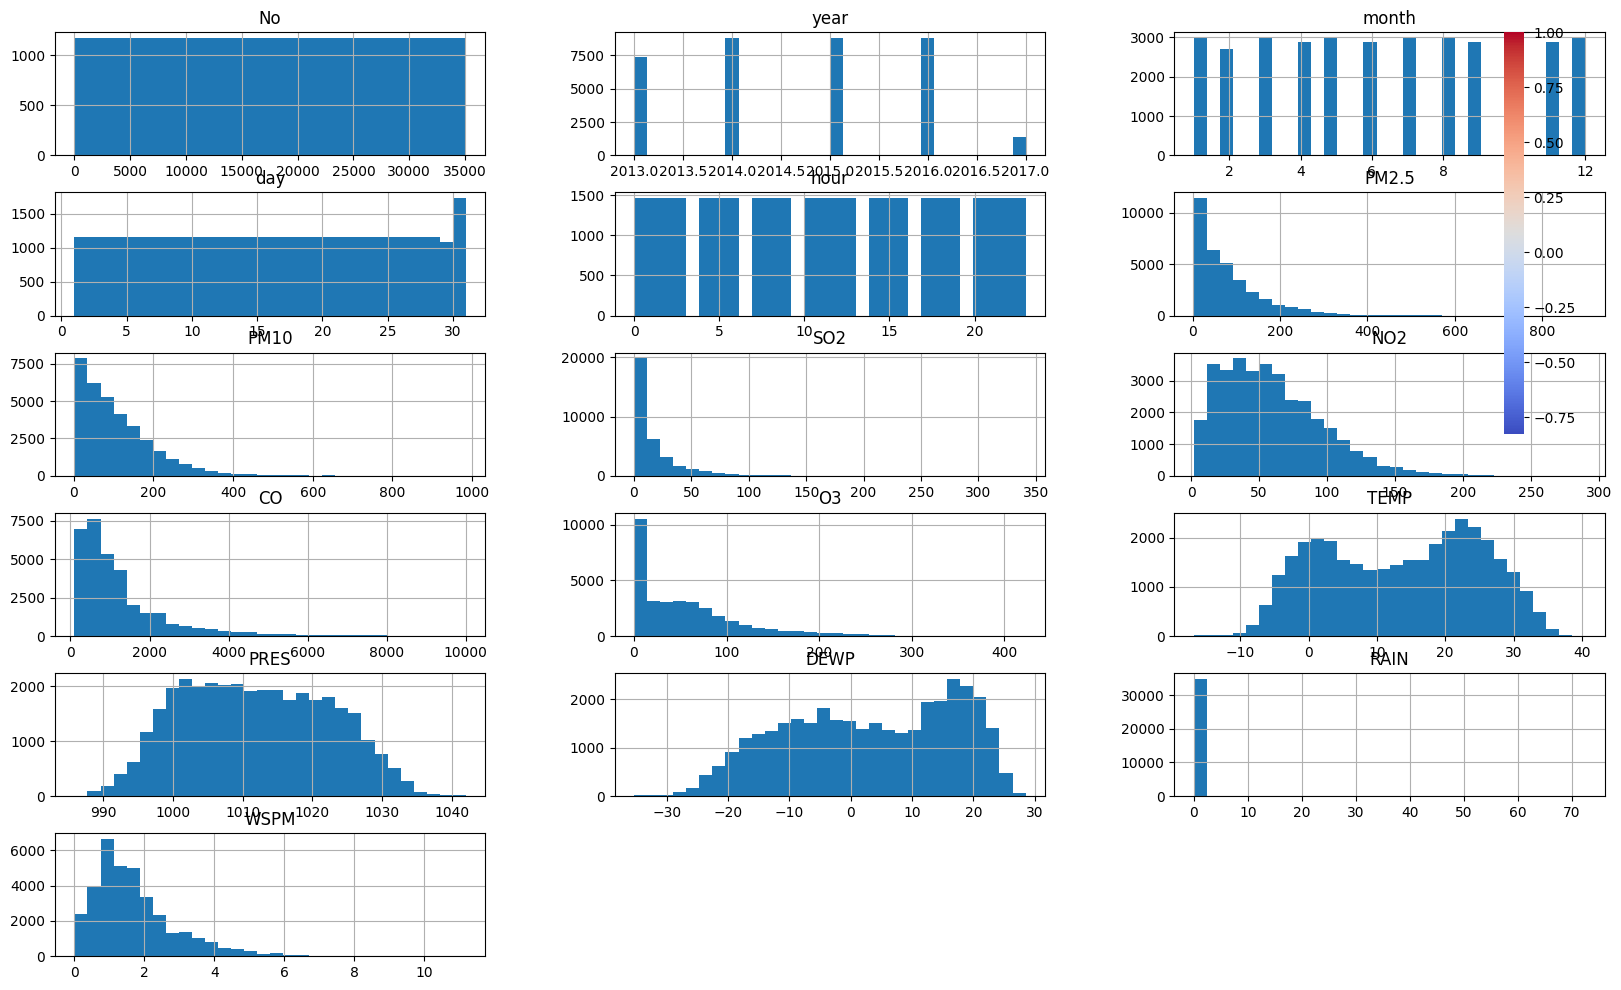


Encoded wd: 17 classes

Encoded station: 1 classes

Final feature columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']

Scaled data shape: (35064, 18)

Scaled data sample:
         No      year     month       day      hour     PM2.5      PM10  \
0 -1.732001 -1.412304 -1.021523 -1.673805 -1.661325 -0.971987 -1.125409   
1 -1.731903 -1.412304 -1.021523 -1.673805 -1.516862 -0.922631 -1.082965   
2 -1.731804 -1.412304 -1.021523 -1.673805 -1.372399 -0.934970 -1.093576   
3 -1.731705 -1.412304 -1.021523 -1.673805 -1.227936 -0.947309 -1.104187   
4 -1.731606 -1.412304 -1.021523 -1.673805 -1.083473 -0.984326 -1.136020   

        SO2       NO2        CO        O3      TEMP      PRES      DEWP  \
0 -0.594053 -1.430285 -0.809141  0.365570 -1.253510  1.072316 -1.602001   
1 -0.594053 -1.430285 -0.809141  0.365570 -1.288611  1.091545 -1.558157   
2 -0.549641 -1.348251 -0.809141  0.294746 -1.288611  1.1

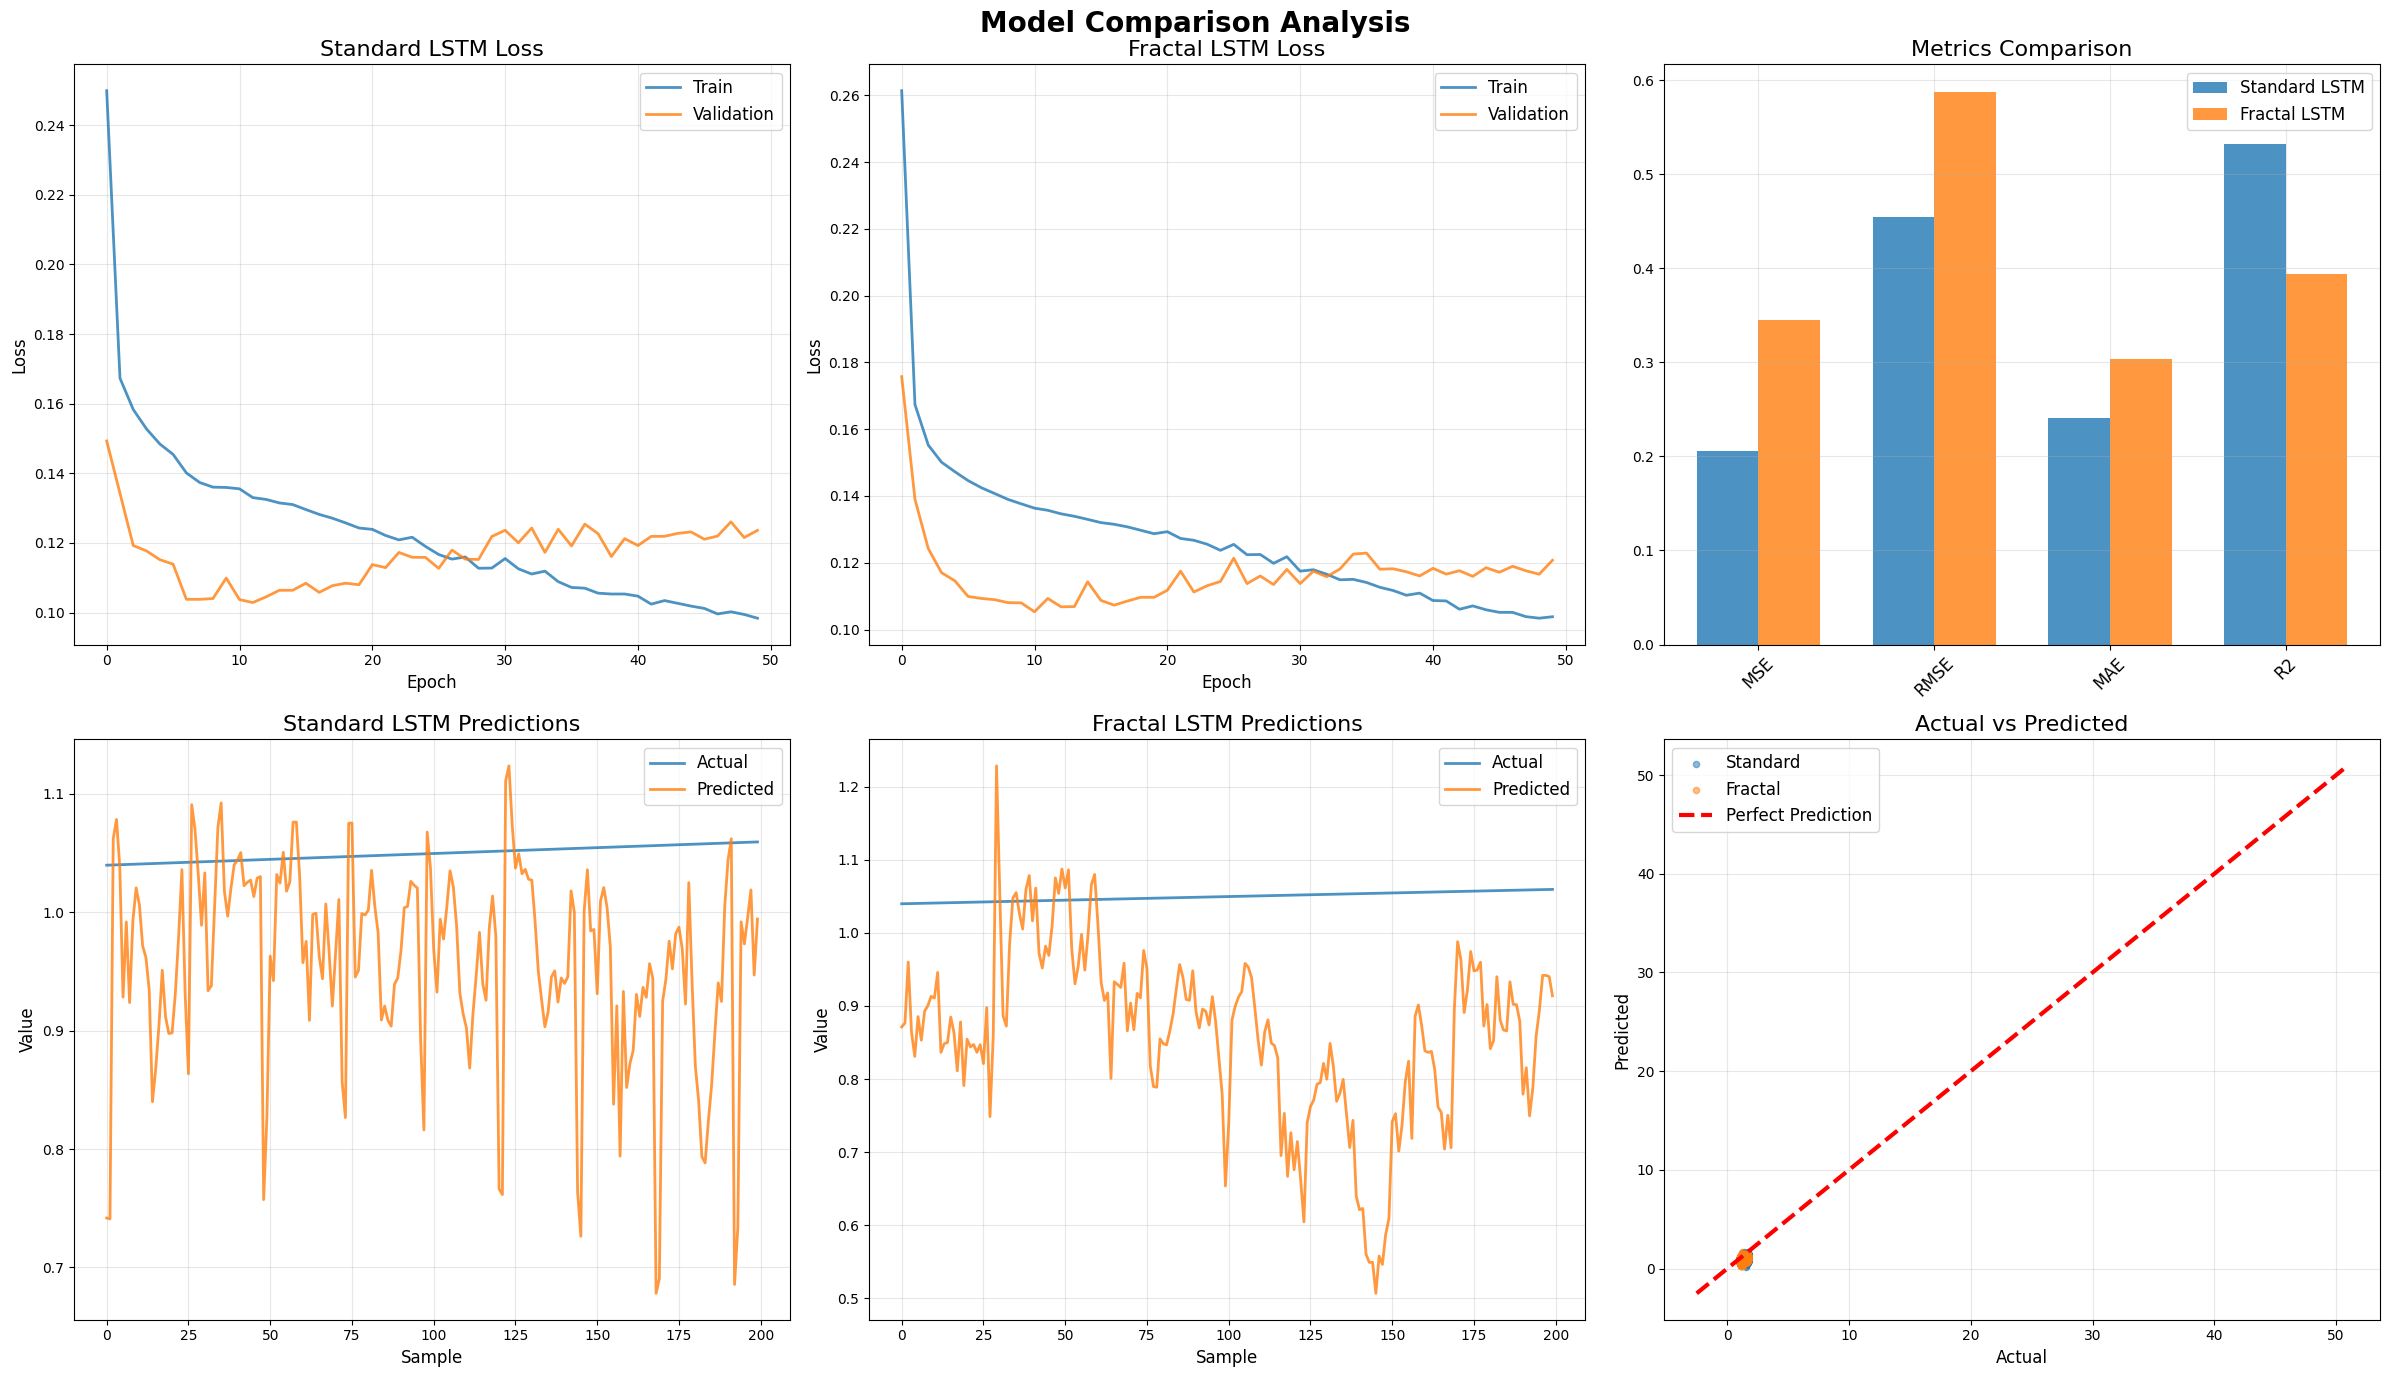


Analysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'

GPU Memory Used: 0.03 GB


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Aotizhongxin_20130301-20170228.csv'
SEQUENCE_LENGTH = 24
HIDDEN_SIZE = 63
FRACTAL_LEVELS = 3
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK")
print("="*80)
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

df = pd.read_csv(FILE_PATH)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Dataset Analysis', fontsize=20, fontweight='bold')

if len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=30, ax=axes[0,0], layout=(len(numeric_cols)//3+1, 3))
    axes[0,0].set_title('Distributions', fontsize=14)
    
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0,1], fmt='.2f', annot_kws={'size': 10})
axes[0,1].set_title('Correlation Matrix', fontsize=14)

if len(numeric_cols) >= 2:
    axes[1,0].plot(df[numeric_cols[0]].values[:200], linewidth=2)
    axes[1,0].set_title(f'{numeric_cols[0]} Time Series (First 200)', fontsize=14)
    axes[1,0].set_xlabel('Time', fontsize=12)
    axes[1,0].set_ylabel('Value', fontsize=12)
    axes[1,0].grid(True, alpha=0.3)

if len(df) > 0:
    axes[1,1].boxplot([df[col].dropna() for col in numeric_cols[:5]], labels=numeric_cols[:5])
    axes[1,1].set_title('Boxplots', fontsize=14)
    axes[1,1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1,1].tick_params(axis='y', labelsize=10)
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

df_processed = df.copy()

for col in categorical_cols:
    if df_processed[col].nunique() < 50:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        print(f"\nEncoded {col}: {df_processed[col].nunique()} classes")

df_processed = df_processed.fillna(df_processed.mean())

feature_cols = [col for col in df_processed.columns if col in numeric_cols or col in categorical_cols]
print(f"\nFinal feature columns: {feature_cols}")

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed[feature_cols]),
    columns=feature_cols
)

print(f"\nScaled data shape: {df_scaled.shape}")
print("\nScaled data sample:")
print(df_scaled.head())

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

data_array = df_scaled.values
X, y = create_sequences(data_array, SEQUENCE_LENGTH)

print(f"\nSequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class FractalMemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_levels):
        super(FractalMemoryCell, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.level_size = hidden_size // num_levels
        
        self.input_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.forget_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.cell_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.output_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        
        self.level_interactions = nn.ModuleList([
            nn.Linear((hidden_size // num_levels) * 2, hidden_size // num_levels) 
            for _ in range(num_levels - 1)
        ])
    
    def forward(self, x, hidden_states, cell_states):
        new_hidden_states = []
        new_cell_states = []
        level_size = self.hidden_size // self.num_levels
        
        for level in range(self.num_levels):
            h_prev = hidden_states[level]
            c_prev = cell_states[level]
            
            combined = torch.cat([x, h_prev], dim=1)
            
            i_t = torch.sigmoid(self.input_gates[level](combined))
            f_t = torch.sigmoid(self.forget_gates[level](combined))
            c_tilde = torch.tanh(self.cell_gates[level](combined))
            o_t = torch.sigmoid(self.output_gates[level](combined))
            
            c_t = f_t * c_prev + i_t * c_tilde
            
            if level > 0:
                interaction = torch.cat([c_t, new_cell_states[level-1]], dim=1)
                c_t = c_t + torch.tanh(self.level_interactions[level-1](interaction))
            
            h_t = o_t * torch.tanh(c_t)
            
            new_hidden_states.append(h_t)
            new_cell_states.append(c_t)
        
        return new_hidden_states, new_cell_states

class FractalMemoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_levels):
        super(FractalMemoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        
        self.fractal_cell = FractalMemoryCell(input_size, hidden_size, num_levels)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        level_size = self.hidden_size // self.num_levels
        
        hidden_states = [torch.zeros(batch_size, level_size, device=x.device) 
                        for _ in range(self.num_levels)]
        cell_states = [torch.zeros(batch_size, level_size, device=x.device) 
                      for _ in range(self.num_levels)]
        
        for t in range(seq_len):
            hidden_states, cell_states = self.fractal_cell(
                x[:, t, :], hidden_states, cell_states
            )
        
        final_hidden = torch.cat(hidden_states, dim=1)
        out = self.fc(final_hidden)
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

standard_lstm = StandardLSTM(input_size, HIDDEN_SIZE, output_size).to(device)
fractal_lstm = FractalMemoryLSTM(input_size, HIDDEN_SIZE, output_size, FRACTAL_LEVELS).to(device)

print(f"\nStandard LSTM parameters: {sum(p.numel() for p in standard_lstm.parameters())}")
print(f"Fractal LSTM parameters: {sum(p.numel() for p in fractal_lstm.parameters())}")

def train_model(model, train_loader, val_loader, epochs, lr, model_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    print(f"\nTraining {model_name}...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return predictions, actuals, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

standard_train_losses, standard_val_losses = train_model(
    standard_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Standard LSTM"
)

fractal_train_losses, fractal_val_losses = train_model(
    fractal_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Fractal Memory LSTM"
)

standard_preds, standard_actuals, standard_metrics = evaluate_model(standard_lstm, test_loader)
fractal_preds, fractal_actuals, fractal_metrics = evaluate_model(fractal_lstm, test_loader)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

print("\nStandard LSTM Metrics:")
for metric, value in standard_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nFractal Memory LSTM Metrics:")
for metric, value in fractal_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\n" + "="*80)
print("COMPARISON")
print("="*80)

for metric in standard_metrics.keys():
    std_val = standard_metrics[metric]
    frac_val = fractal_metrics[metric]
    
    if metric == 'R2':
        improvement = ((frac_val - std_val) / abs(std_val)) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val > std_val else "Standard"
    else:
        improvement = ((std_val - frac_val) / std_val) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val < std_val else "Standard"
    
    print(f"{metric}: {better} LSTM better by {abs(improvement):.2f}%")

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Model Comparison Analysis', fontsize=20, fontweight='bold')

axes[0,0].plot(standard_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,0].plot(standard_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,0].set_title('Standard LSTM Loss', fontsize=16)
axes[0,0].set_xlabel('Epoch', fontsize=12)
axes[0,0].set_ylabel('Loss', fontsize=12)
axes[0,0].legend(fontsize=12)
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(fractal_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,1].plot(fractal_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,1].set_title('Fractal LSTM Loss', fontsize=16)
axes[0,1].set_xlabel('Epoch', fontsize=12)
axes[0,1].set_ylabel('Loss', fontsize=12)
axes[0,1].legend(fontsize=12)
axes[0,1].grid(True, alpha=0.3)

metrics_names = list(standard_metrics.keys())
standard_values = [standard_metrics[m] for m in metrics_names]
fractal_values = [fractal_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[0,2].bar(x - width/2, standard_values, width, label='Standard LSTM', alpha=0.8)
axes[0,2].bar(x + width/2, fractal_values, width, label='Fractal LSTM', alpha=0.8)
axes[0,2].set_title('Metrics Comparison', fontsize=16)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(metrics_names, rotation=45, fontsize=12)
axes[0,2].legend(fontsize=12)
axes[0,2].grid(True, alpha=0.3)

sample_size = min(200, len(standard_actuals))
axes[1,0].plot(standard_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,0].plot(standard_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,0].set_title('Standard LSTM Predictions', fontsize=16)
axes[1,0].set_xlabel('Sample', fontsize=12)
axes[1,0].set_ylabel('Value', fontsize=12)
axes[1,0].legend(fontsize=12)
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(fractal_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,1].plot(fractal_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,1].set_title('Fractal LSTM Predictions', fontsize=16)
axes[1,1].set_xlabel('Sample', fontsize=12)
axes[1,1].set_ylabel('Value', fontsize=12)
axes[1,1].legend(fontsize=12)
axes[1,1].grid(True, alpha=0.3)

axes[1,2].scatter(standard_actuals[:, 0], standard_preds[:, 0], alpha=0.5, label='Standard', s=20)
axes[1,2].scatter(fractal_actuals[:, 0], fractal_preds[:, 0], alpha=0.5, label='Fractal', s=20)
axes[1,2].plot([standard_actuals.min(), standard_actuals.max()], 
               [standard_actuals.min(), standard_actuals.max()], 
               'r--', lw=3, label='Perfect Prediction')
axes[1,2].set_title('Actual vs Predicted', fontsize=16)
axes[1,2].set_xlabel('Actual', fontsize=12)
axes[1,2].set_ylabel('Predicted', fontsize=12)
axes[1,2].legend(fontsize=12)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'")

if torch.cuda.is_available():
    print(f"\nGPU Memory Used: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")
    torch.cuda.empty_cache()

FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Dataset Shape: (2000, 7)
Columns: ['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours', 'CaffeineIntake', 'RelaxationTime', 'SleepTime']

First 10 rows:
   WorkoutTime  ReadingTime  PhoneTime  WorkHours  CaffeineIntake  \
0         1.12         0.52       3.29       7.89          216.08   
1         2.85         0.49       4.22       5.03          206.18   
2         2.20         1.81       4.04       9.23           28.73   
3         1.80         0.50       1.62       7.68          276.77   
4         0.47         0.54       1.60       4.94          170.54   
5         0.47         1.52       2.07       9.77          109.12   
6         0.17         0.90       2.44       7.11          226.96   
7         2.60         1.55       2.63       4.44           77.21   
8         1.80         0.13       3.72       7.76          208.05   
9         2.12         0.98       1.23 

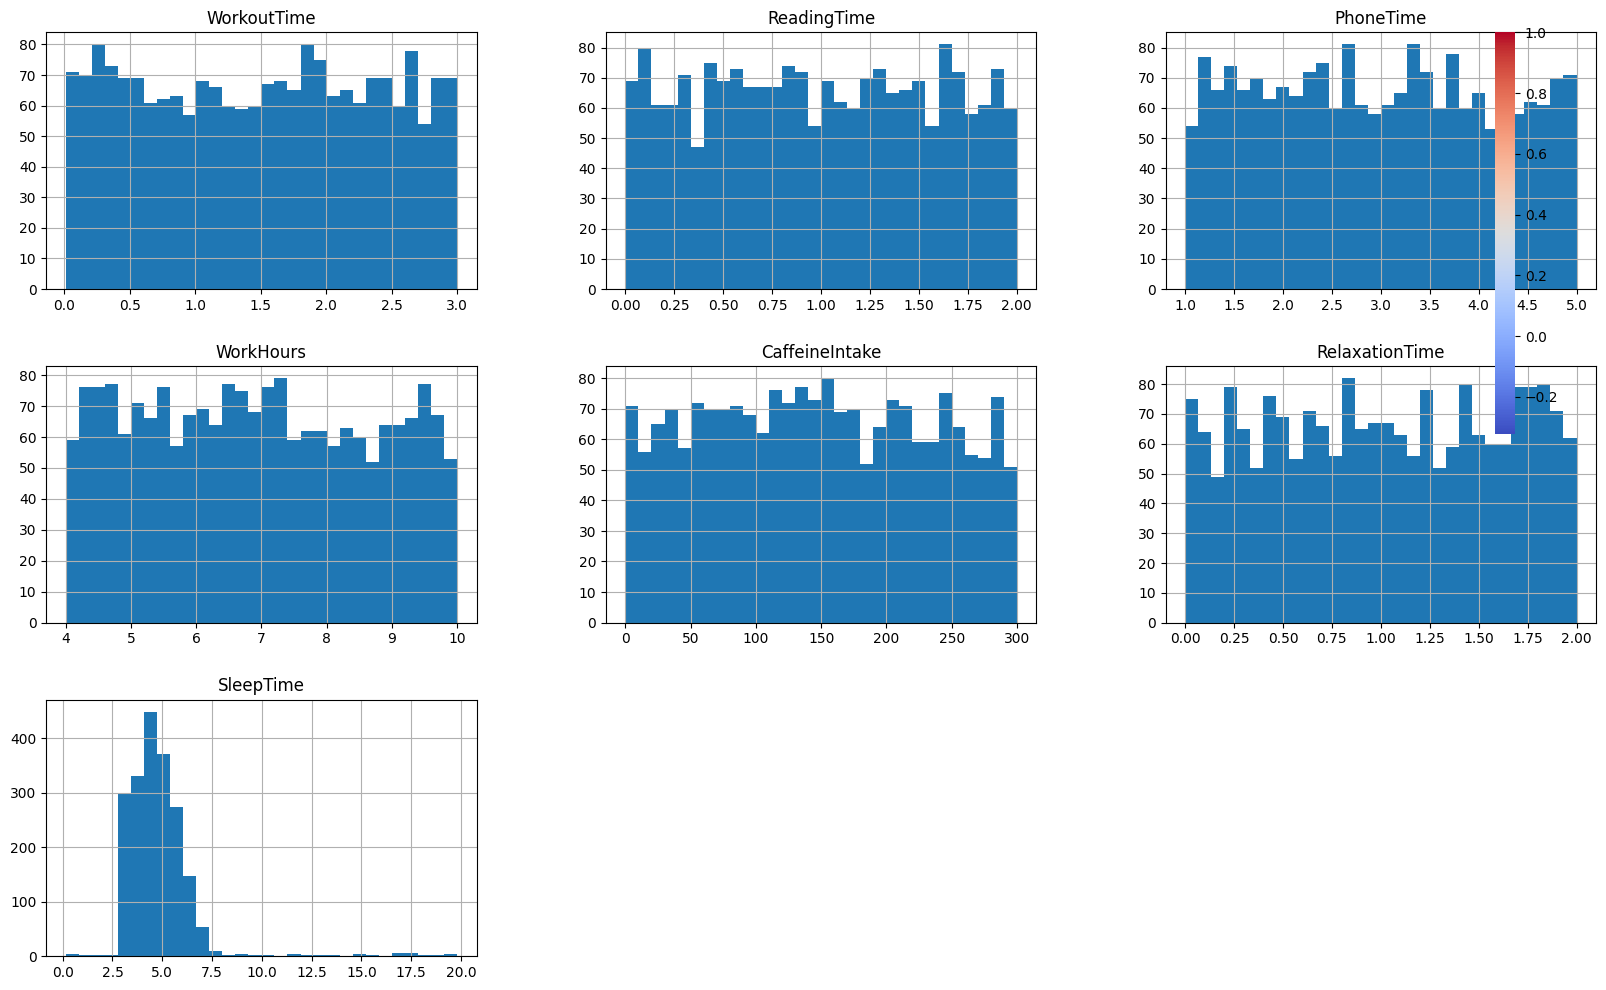


Final feature columns: ['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours', 'CaffeineIntake', 'RelaxationTime', 'SleepTime']

Scaled data shape: (2000, 7)

Scaled data sample:
   WorkoutTime  ReadingTime  PhoneTime  WorkHours  CaffeineIntake  \
0    -0.428921    -0.819160   0.264705   0.558807        0.810425   
1     1.545018    -0.871139   1.072356  -1.100692        0.693445   
2     0.803365     1.415929   0.916036   1.336335       -1.403330   
3     0.346963    -0.853813  -1.185592   0.436956        1.527546   
4    -1.170574    -0.784507  -1.202961  -1.152914        0.272317   

   RelaxationTime  SleepTime  
0       -0.448012  -0.707151  
1       -0.585357  -0.002157  
2       -1.134738  -0.628271  
3        0.341724   0.027423  
4       -0.104648   0.303505  

Sequences shape: (1976, 24, 7)
Targets shape: (1976, 7)

Train: (1264, 24, 7), Val: (316, 24, 7), Test: (396, 24, 7)

Standard LSTM parameters: 18592
Fractal LSTM parameters: 9562

Training Standard LSTM...
Epoch 10/5

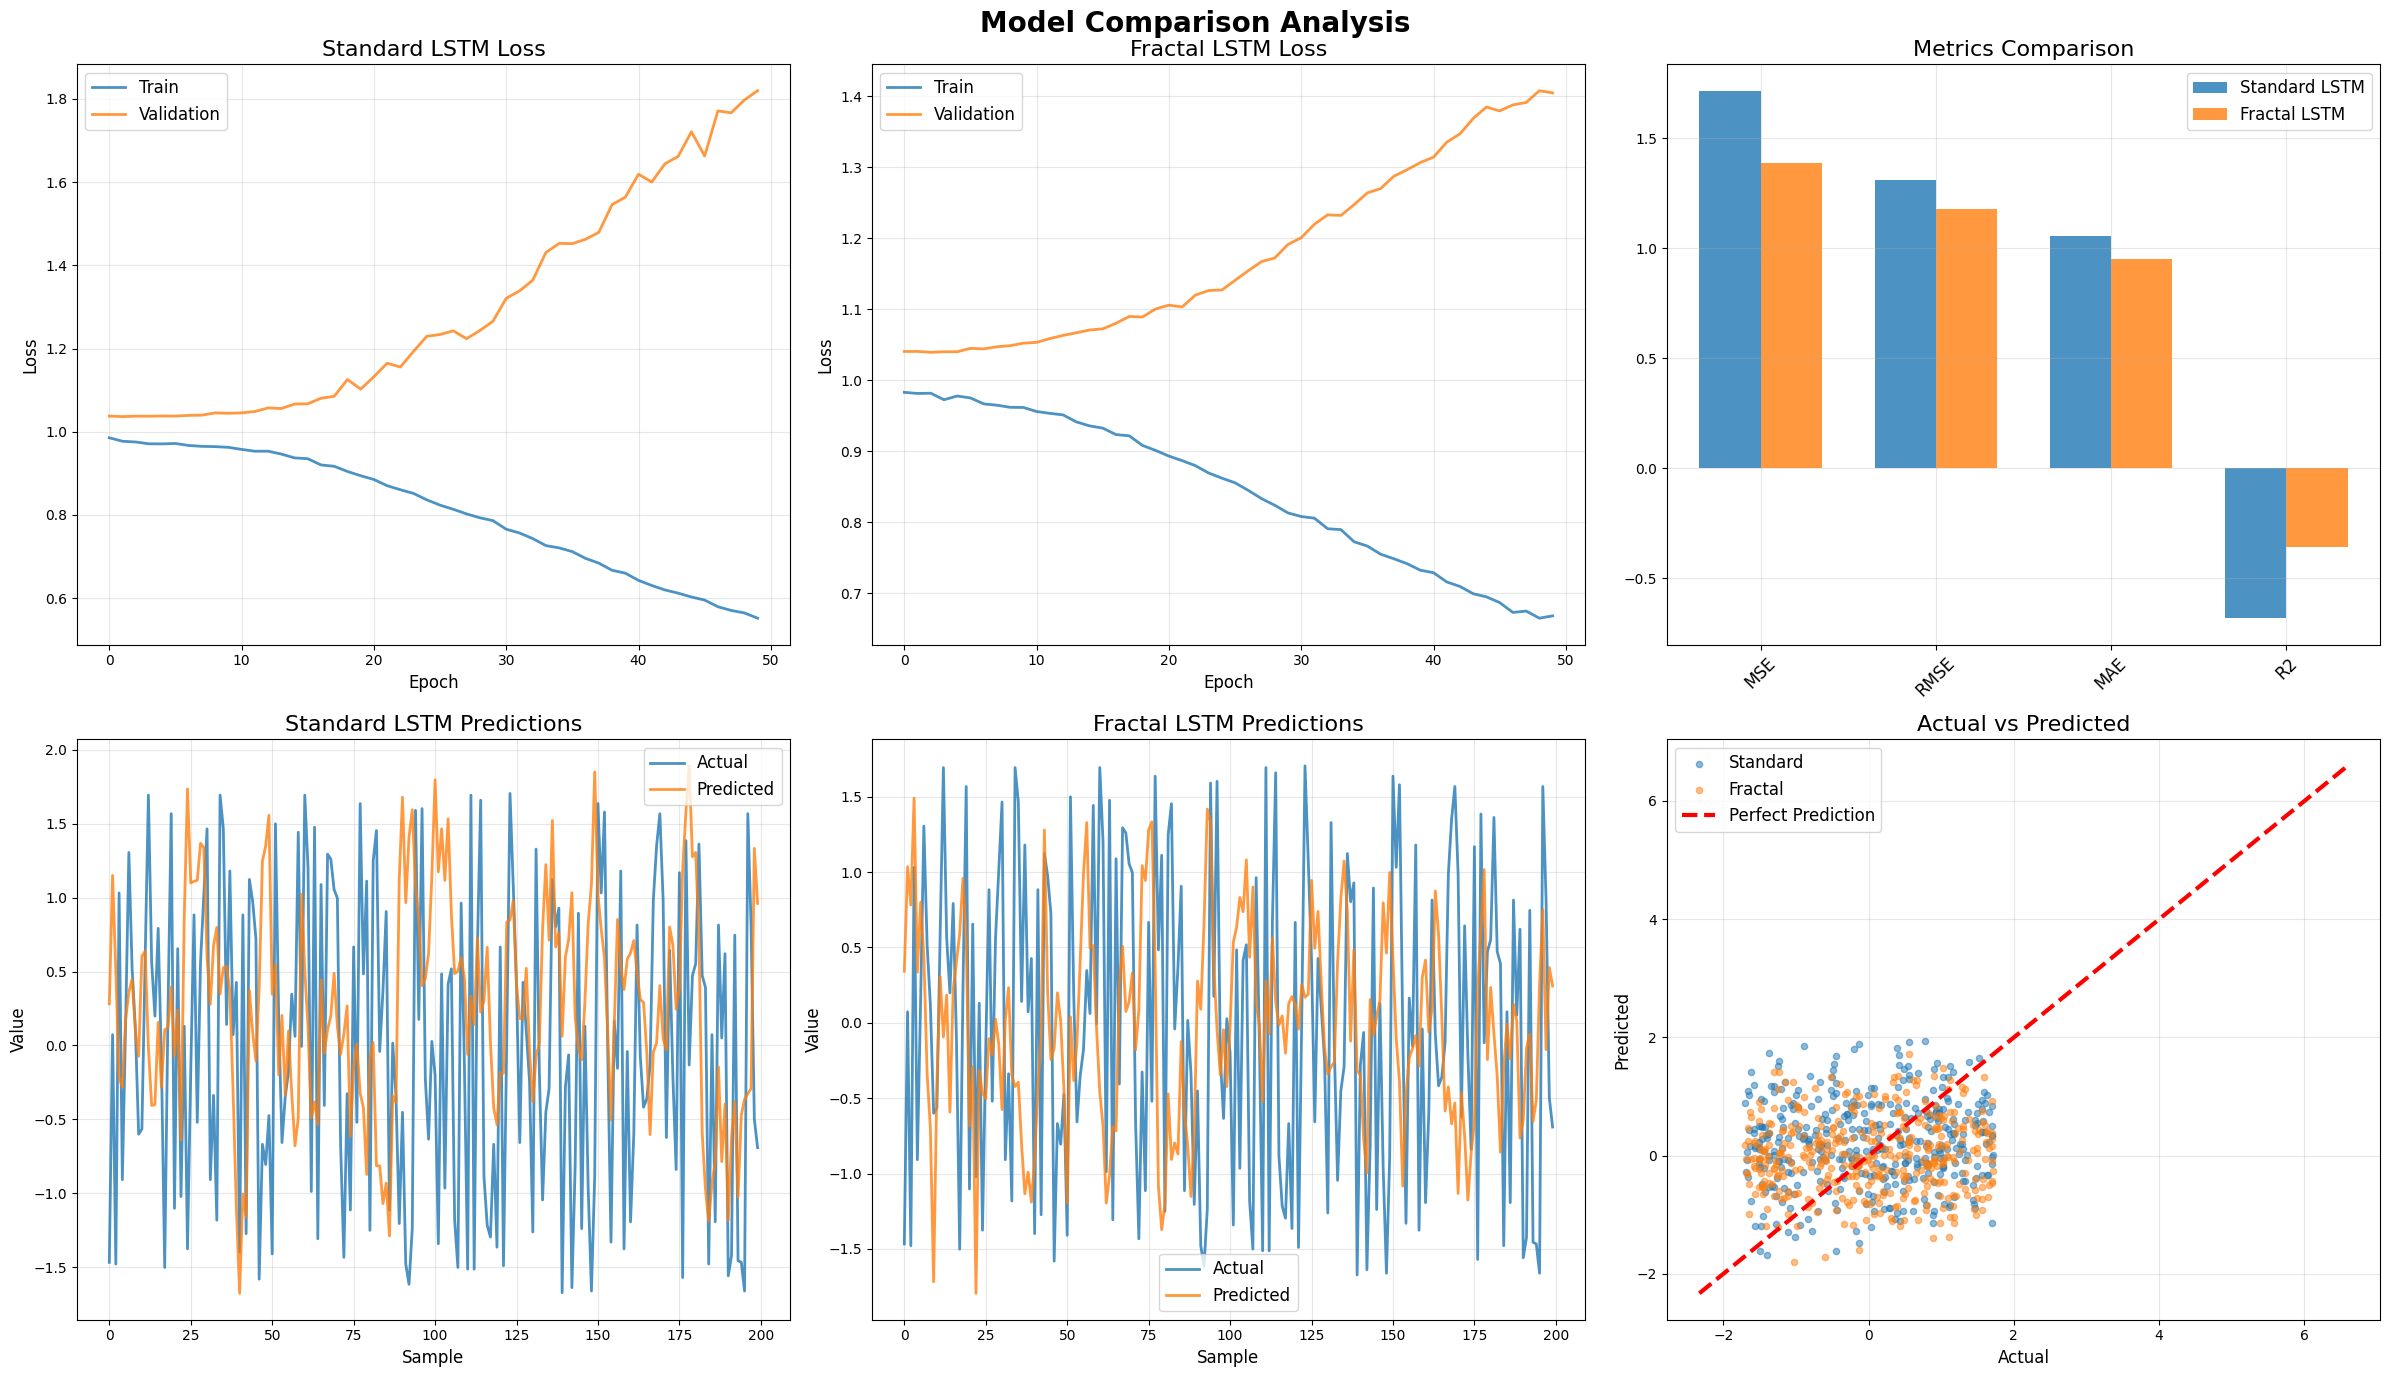


Analysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'

GPU Memory Used: 0.03 GB


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '/kaggle/input/sleep-time-prediction/sleeptime_prediction_dataset.csv'
SEQUENCE_LENGTH = 24
HIDDEN_SIZE = 63
FRACTAL_LEVELS = 3
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK")
print("="*80)
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

df = pd.read_csv(FILE_PATH)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Dataset Analysis', fontsize=20, fontweight='bold')

if len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=30, ax=axes[0,0], layout=(len(numeric_cols)//3+1, 3))
    axes[0,0].set_title('Distributions', fontsize=14)
    
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0,1], fmt='.2f', annot_kws={'size': 10})
axes[0,1].set_title('Correlation Matrix', fontsize=14)

if len(numeric_cols) >= 2:
    axes[1,0].plot(df[numeric_cols[0]].values[:200], linewidth=2)
    axes[1,0].set_title(f'{numeric_cols[0]} Time Series (First 200)', fontsize=14)
    axes[1,0].set_xlabel('Time', fontsize=12)
    axes[1,0].set_ylabel('Value', fontsize=12)
    axes[1,0].grid(True, alpha=0.3)

if len(df) > 0:
    axes[1,1].boxplot([df[col].dropna() for col in numeric_cols[:5]], labels=numeric_cols[:5])
    axes[1,1].set_title('Boxplots', fontsize=14)
    axes[1,1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1,1].tick_params(axis='y', labelsize=10)
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

df_processed = df.copy()

for col in categorical_cols:
    if df_processed[col].nunique() < 50:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        print(f"\nEncoded {col}: {df_processed[col].nunique()} classes")

df_processed = df_processed.fillna(df_processed.mean())

feature_cols = [col for col in df_processed.columns if col in numeric_cols or col in categorical_cols]
print(f"\nFinal feature columns: {feature_cols}")

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed[feature_cols]),
    columns=feature_cols
)

print(f"\nScaled data shape: {df_scaled.shape}")
print("\nScaled data sample:")
print(df_scaled.head())

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

data_array = df_scaled.values
X, y = create_sequences(data_array, SEQUENCE_LENGTH)

print(f"\nSequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class FractalMemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_levels):
        super(FractalMemoryCell, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.level_size = hidden_size // num_levels
        
        self.input_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.forget_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.cell_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.output_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        
        self.level_interactions = nn.ModuleList([
            nn.Linear((hidden_size // num_levels) * 2, hidden_size // num_levels) 
            for _ in range(num_levels - 1)
        ])
    
    def forward(self, x, hidden_states, cell_states):
        new_hidden_states = []
        new_cell_states = []
        level_size = self.hidden_size // self.num_levels
        
        for level in range(self.num_levels):
            h_prev = hidden_states[level]
            c_prev = cell_states[level]
            
            combined = torch.cat([x, h_prev], dim=1)
            
            i_t = torch.sigmoid(self.input_gates[level](combined))
            f_t = torch.sigmoid(self.forget_gates[level](combined))
            c_tilde = torch.tanh(self.cell_gates[level](combined))
            o_t = torch.sigmoid(self.output_gates[level](combined))
            
            c_t = f_t * c_prev + i_t * c_tilde
            
            if level > 0:
                interaction = torch.cat([c_t, new_cell_states[level-1]], dim=1)
                c_t = c_t + torch.tanh(self.level_interactions[level-1](interaction))
            
            h_t = o_t * torch.tanh(c_t)
            
            new_hidden_states.append(h_t)
            new_cell_states.append(c_t)
        
        return new_hidden_states, new_cell_states

class FractalMemoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_levels):
        super(FractalMemoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        
        self.fractal_cell = FractalMemoryCell(input_size, hidden_size, num_levels)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        level_size = self.hidden_size // self.num_levels
        
        hidden_states = [torch.zeros(batch_size, level_size, device=x.device) 
                        for _ in range(self.num_levels)]
        cell_states = [torch.zeros(batch_size, level_size, device=x.device) 
                      for _ in range(self.num_levels)]
        
        for t in range(seq_len):
            hidden_states, cell_states = self.fractal_cell(
                x[:, t, :], hidden_states, cell_states
            )
        
        final_hidden = torch.cat(hidden_states, dim=1)
        out = self.fc(final_hidden)
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

standard_lstm = StandardLSTM(input_size, HIDDEN_SIZE, output_size).to(device)
fractal_lstm = FractalMemoryLSTM(input_size, HIDDEN_SIZE, output_size, FRACTAL_LEVELS).to(device)

print(f"\nStandard LSTM parameters: {sum(p.numel() for p in standard_lstm.parameters())}")
print(f"Fractal LSTM parameters: {sum(p.numel() for p in fractal_lstm.parameters())}")

def train_model(model, train_loader, val_loader, epochs, lr, model_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    print(f"\nTraining {model_name}...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return predictions, actuals, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

standard_train_losses, standard_val_losses = train_model(
    standard_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Standard LSTM"
)

fractal_train_losses, fractal_val_losses = train_model(
    fractal_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Fractal Memory LSTM"
)

standard_preds, standard_actuals, standard_metrics = evaluate_model(standard_lstm, test_loader)
fractal_preds, fractal_actuals, fractal_metrics = evaluate_model(fractal_lstm, test_loader)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

print("\nStandard LSTM Metrics:")
for metric, value in standard_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nFractal Memory LSTM Metrics:")
for metric, value in fractal_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\n" + "="*80)
print("COMPARISON")
print("="*80)

for metric in standard_metrics.keys():
    std_val = standard_metrics[metric]
    frac_val = fractal_metrics[metric]
    
    if metric == 'R2':
        improvement = ((frac_val - std_val) / abs(std_val)) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val > std_val else "Standard"
    else:
        improvement = ((std_val - frac_val) / std_val) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val < std_val else "Standard"
    
    print(f"{metric}: {better} LSTM better by {abs(improvement):.2f}%")

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Model Comparison Analysis', fontsize=20, fontweight='bold')

axes[0,0].plot(standard_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,0].plot(standard_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,0].set_title('Standard LSTM Loss', fontsize=16)
axes[0,0].set_xlabel('Epoch', fontsize=12)
axes[0,0].set_ylabel('Loss', fontsize=12)
axes[0,0].legend(fontsize=12)
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(fractal_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,1].plot(fractal_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,1].set_title('Fractal LSTM Loss', fontsize=16)
axes[0,1].set_xlabel('Epoch', fontsize=12)
axes[0,1].set_ylabel('Loss', fontsize=12)
axes[0,1].legend(fontsize=12)
axes[0,1].grid(True, alpha=0.3)

metrics_names = list(standard_metrics.keys())
standard_values = [standard_metrics[m] for m in metrics_names]
fractal_values = [fractal_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[0,2].bar(x - width/2, standard_values, width, label='Standard LSTM', alpha=0.8)
axes[0,2].bar(x + width/2, fractal_values, width, label='Fractal LSTM', alpha=0.8)
axes[0,2].set_title('Metrics Comparison', fontsize=16)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(metrics_names, rotation=45, fontsize=12)
axes[0,2].legend(fontsize=12)
axes[0,2].grid(True, alpha=0.3)

sample_size = min(200, len(standard_actuals))
axes[1,0].plot(standard_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,0].plot(standard_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,0].set_title('Standard LSTM Predictions', fontsize=16)
axes[1,0].set_xlabel('Sample', fontsize=12)
axes[1,0].set_ylabel('Value', fontsize=12)
axes[1,0].legend(fontsize=12)
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(fractal_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,1].plot(fractal_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,1].set_title('Fractal LSTM Predictions', fontsize=16)
axes[1,1].set_xlabel('Sample', fontsize=12)
axes[1,1].set_ylabel('Value', fontsize=12)
axes[1,1].legend(fontsize=12)
axes[1,1].grid(True, alpha=0.3)

axes[1,2].scatter(standard_actuals[:, 0], standard_preds[:, 0], alpha=0.5, label='Standard', s=20)
axes[1,2].scatter(fractal_actuals[:, 0], fractal_preds[:, 0], alpha=0.5, label='Fractal', s=20)
axes[1,2].plot([standard_actuals.min(), standard_actuals.max()], 
               [standard_actuals.min(), standard_actuals.max()], 
               'r--', lw=3, label='Perfect Prediction')
axes[1,2].set_title('Actual vs Predicted', fontsize=16)
axes[1,2].set_xlabel('Actual', fontsize=12)
axes[1,2].set_ylabel('Predicted', fontsize=12)
axes[1,2].legend(fontsize=12)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'")

if torch.cuda.is_available():
    print(f"\nGPU Memory Used: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")
    torch.cuda.empty_cache()

FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Dataset Shape: (59, 18)
Columns: ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'metANN']

First 10 rows:
   YEAR     JAN     FEB     MAR     APR     MAY     JUN     JUL     AUG  \
0  1961   26.43   25.53   25.88   26.07   26.31   26.64   26.77   26.72   
1  1962   26.30   26.06   26.15   26.04   26.83   26.74   26.71   26.94   
2  1963   26.25   26.03   26.02   26.42   27.17   26.94   26.93   26.98   
3  1964   25.70   25.52   25.41   25.75   26.55   26.91   27.16   27.34   
4  1965  999.90  999.90  999.90  999.90  999.90  999.90  999.90  999.90   
5  1966  999.90  999.90  999.90  999.90  999.90  999.90  999.90  999.90   
6  1967   26.55   25.99   25.93   26.24   26.33   26.43   26.19   26.00   
7  1968   25.99  999.90   25.74  999.90  999.90   26.38   26.67   26.76   
8  1969   26.64   27.1

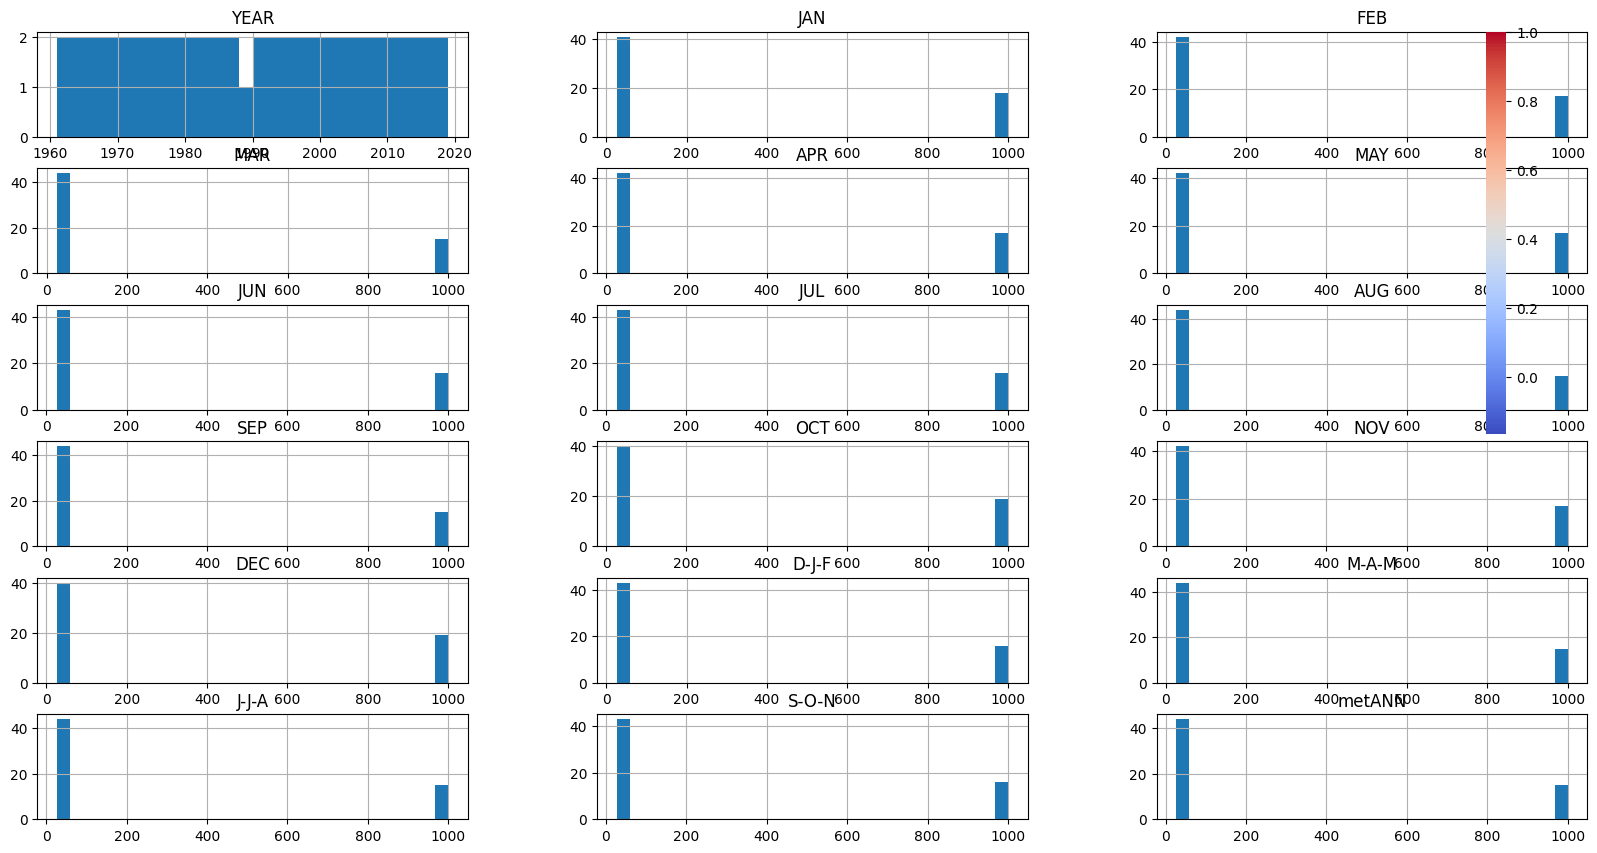


Final feature columns: ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'metANN']

Scaled data shape: (59, 18)

Scaled data sample:
       YEAR       JAN       FEB       MAR       APR       MAY       JUN  \
0 -1.702939 -0.663894 -0.639347 -0.586400 -0.638911 -0.638967 -0.612009   
1 -1.644217 -0.664184 -0.638144 -0.585762 -0.638979 -0.637786 -0.611778   
2 -1.585495 -0.664295 -0.638212 -0.586069 -0.638116 -0.637014 -0.611315   
3 -1.526773 -0.665523 -0.639370 -0.587509 -0.639637 -0.638422 -0.611384   
4 -1.468051  1.509229  1.571809  1.712696  1.571809  1.571809  1.639358   

        JUL       AUG       SEP       OCT       NOV       DEC     D-J-F  \
0 -0.611449 -0.585971 -0.586252 -0.691945 -0.639190 -0.691590 -0.612198   
1 -0.611588 -0.585451 -0.585661 -0.691196 -0.638781 -0.690709 -0.611967   
2 -0.611079 -0.585357 -0.585449 -0.691086 -0.637918 -0.692184 -0.611712   
3 -0.610547 -0.584506 -0.584598  1.4

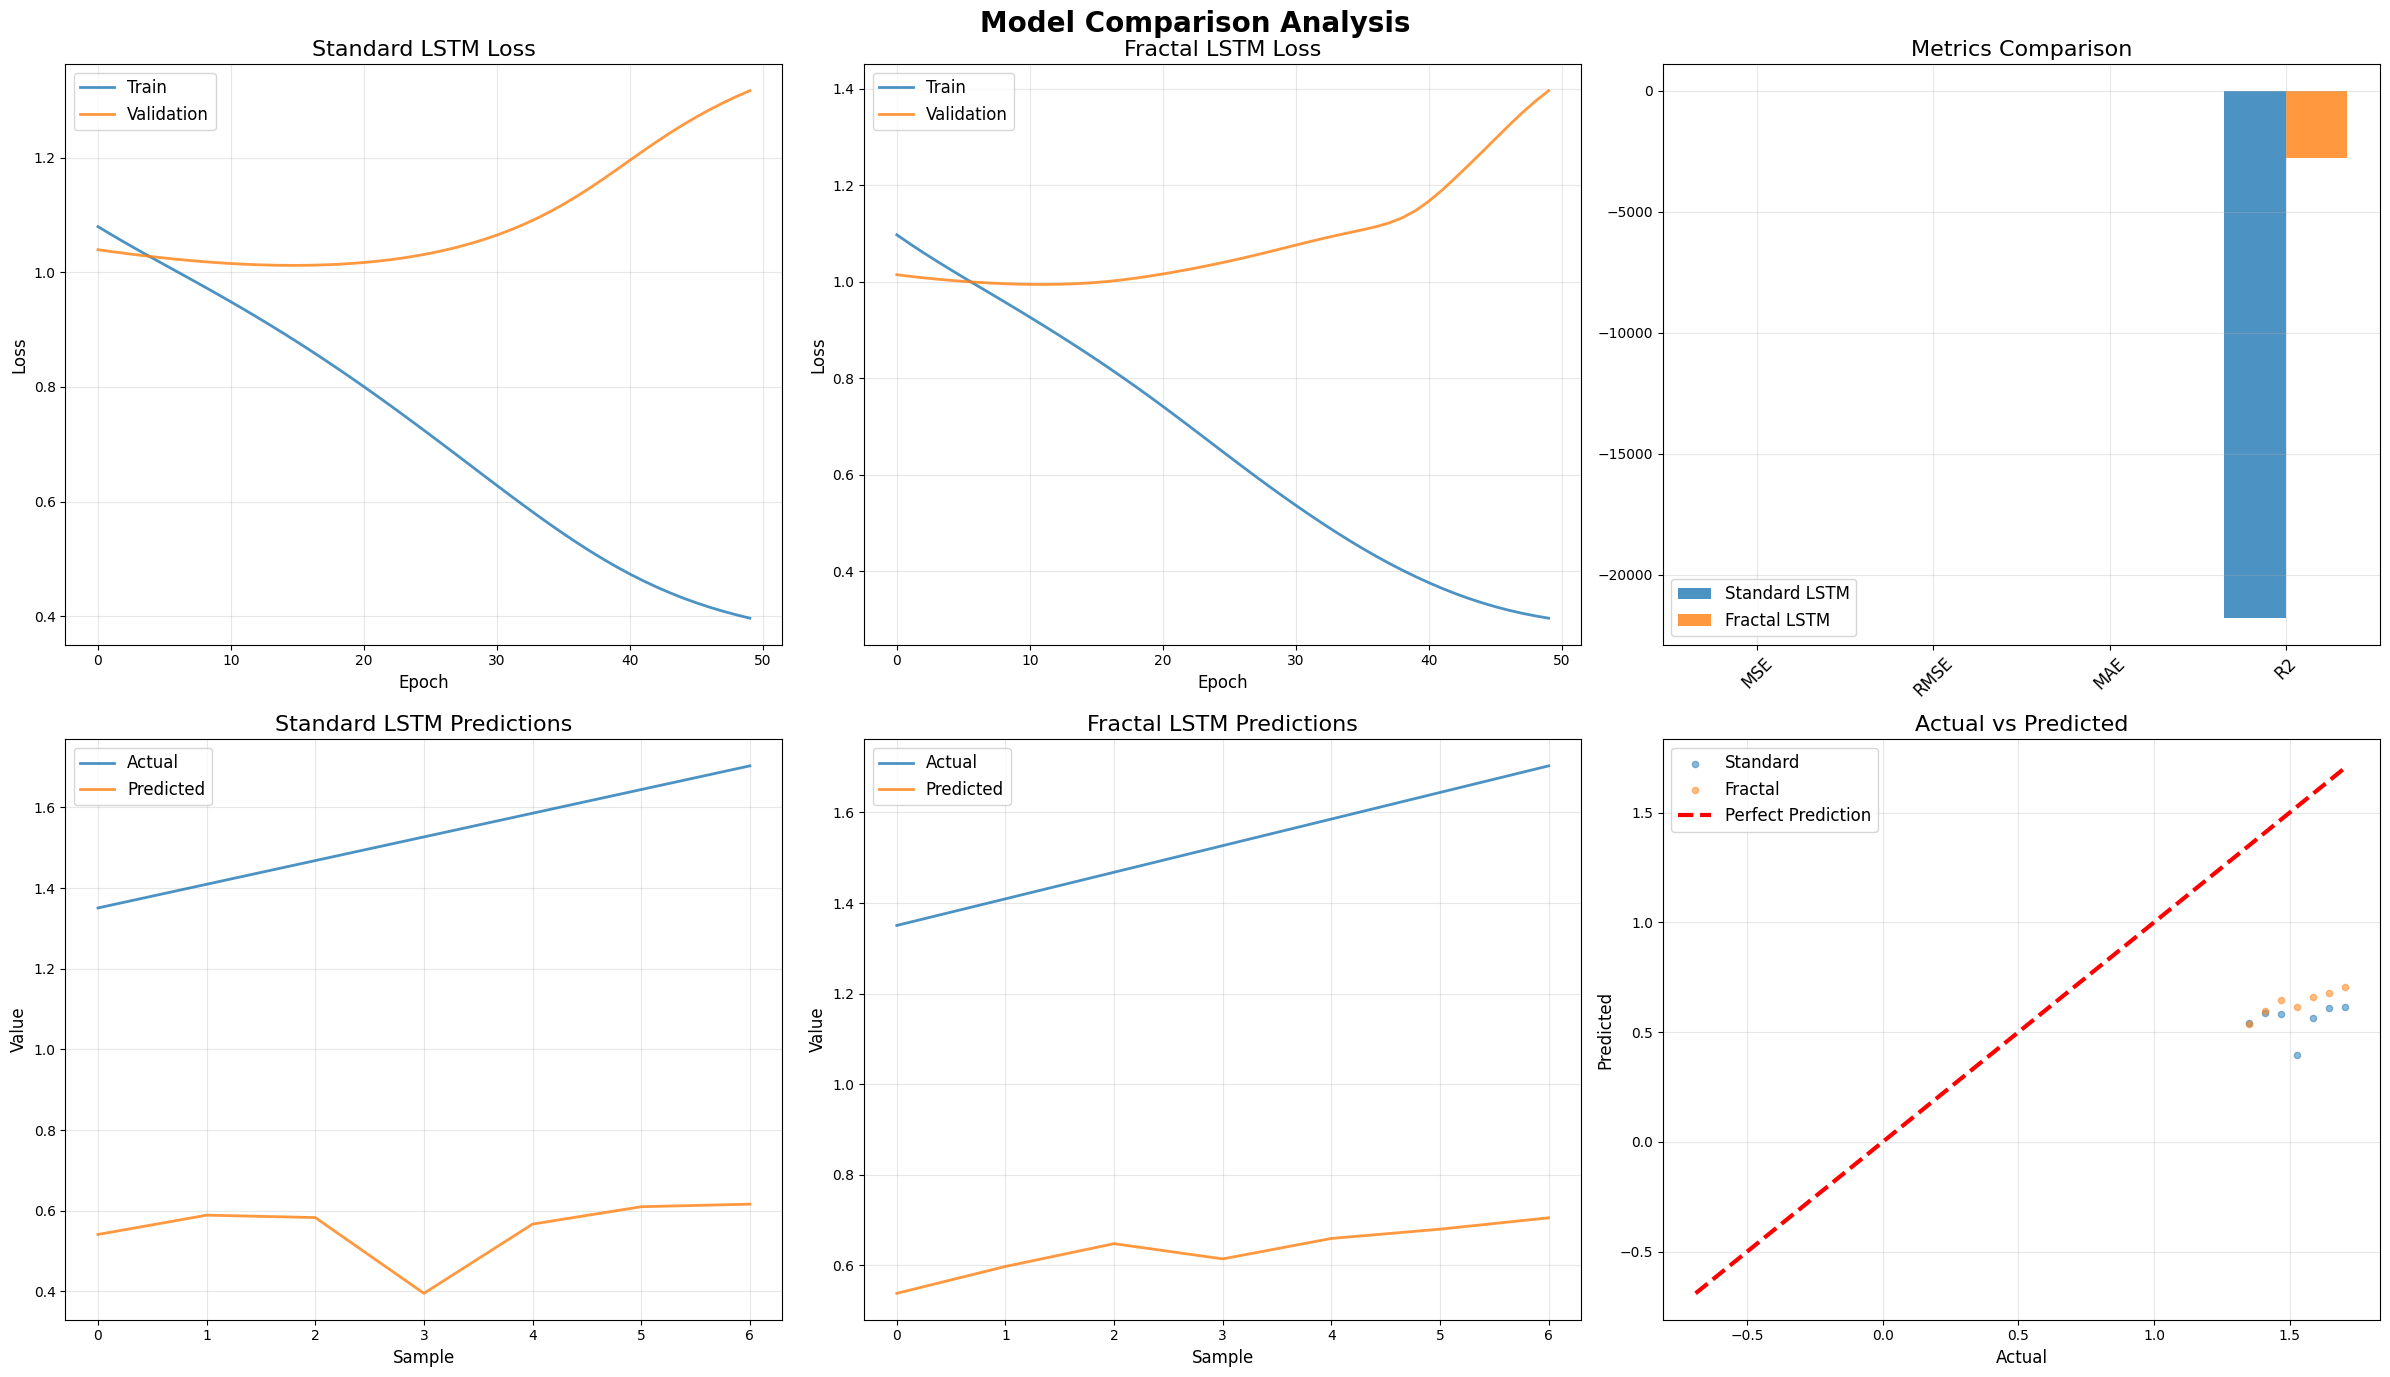


Analysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'

GPU Memory Used: 0.03 GB


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_belem.csv'
SEQUENCE_LENGTH = 24
HIDDEN_SIZE = 63
FRACTAL_LEVELS = 3
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK")
print("="*80)
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

df = pd.read_csv(FILE_PATH)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Dataset Analysis', fontsize=20, fontweight='bold')

if len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=30, ax=axes[0,0], layout=(len(numeric_cols)//3+1, 3))
    axes[0,0].set_title('Distributions', fontsize=14)
    
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0,1], fmt='.2f', annot_kws={'size': 10})
axes[0,1].set_title('Correlation Matrix', fontsize=14)

if len(numeric_cols) >= 2:
    axes[1,0].plot(df[numeric_cols[0]].values[:200], linewidth=2)
    axes[1,0].set_title(f'{numeric_cols[0]} Time Series (First 200)', fontsize=14)
    axes[1,0].set_xlabel('Time', fontsize=12)
    axes[1,0].set_ylabel('Value', fontsize=12)
    axes[1,0].grid(True, alpha=0.3)

if len(df) > 0:
    axes[1,1].boxplot([df[col].dropna() for col in numeric_cols[:5]], labels=numeric_cols[:5])
    axes[1,1].set_title('Boxplots', fontsize=14)
    axes[1,1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1,1].tick_params(axis='y', labelsize=10)
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

df_processed = df.copy()

for col in categorical_cols:
    if df_processed[col].nunique() < 50:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        print(f"\nEncoded {col}: {df_processed[col].nunique()} classes")

df_processed = df_processed.fillna(df_processed.mean())

feature_cols = [col for col in df_processed.columns if col in numeric_cols or col in categorical_cols]
print(f"\nFinal feature columns: {feature_cols}")

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed[feature_cols]),
    columns=feature_cols
)

print(f"\nScaled data shape: {df_scaled.shape}")
print("\nScaled data sample:")
print(df_scaled.head())

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

data_array = df_scaled.values
X, y = create_sequences(data_array, SEQUENCE_LENGTH)

print(f"\nSequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class FractalMemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_levels):
        super(FractalMemoryCell, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.level_size = hidden_size // num_levels
        
        self.input_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.forget_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.cell_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.output_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        
        self.level_interactions = nn.ModuleList([
            nn.Linear((hidden_size // num_levels) * 2, hidden_size // num_levels) 
            for _ in range(num_levels - 1)
        ])
    
    def forward(self, x, hidden_states, cell_states):
        new_hidden_states = []
        new_cell_states = []
        level_size = self.hidden_size // self.num_levels
        
        for level in range(self.num_levels):
            h_prev = hidden_states[level]
            c_prev = cell_states[level]
            
            combined = torch.cat([x, h_prev], dim=1)
            
            i_t = torch.sigmoid(self.input_gates[level](combined))
            f_t = torch.sigmoid(self.forget_gates[level](combined))
            c_tilde = torch.tanh(self.cell_gates[level](combined))
            o_t = torch.sigmoid(self.output_gates[level](combined))
            
            c_t = f_t * c_prev + i_t * c_tilde
            
            if level > 0:
                interaction = torch.cat([c_t, new_cell_states[level-1]], dim=1)
                c_t = c_t + torch.tanh(self.level_interactions[level-1](interaction))
            
            h_t = o_t * torch.tanh(c_t)
            
            new_hidden_states.append(h_t)
            new_cell_states.append(c_t)
        
        return new_hidden_states, new_cell_states

class FractalMemoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_levels):
        super(FractalMemoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        
        self.fractal_cell = FractalMemoryCell(input_size, hidden_size, num_levels)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        level_size = self.hidden_size // self.num_levels
        
        hidden_states = [torch.zeros(batch_size, level_size, device=x.device) 
                        for _ in range(self.num_levels)]
        cell_states = [torch.zeros(batch_size, level_size, device=x.device) 
                      for _ in range(self.num_levels)]
        
        for t in range(seq_len):
            hidden_states, cell_states = self.fractal_cell(
                x[:, t, :], hidden_states, cell_states
            )
        
        final_hidden = torch.cat(hidden_states, dim=1)
        out = self.fc(final_hidden)
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

standard_lstm = StandardLSTM(input_size, HIDDEN_SIZE, output_size).to(device)
fractal_lstm = FractalMemoryLSTM(input_size, HIDDEN_SIZE, output_size, FRACTAL_LEVELS).to(device)

print(f"\nStandard LSTM parameters: {sum(p.numel() for p in standard_lstm.parameters())}")
print(f"Fractal LSTM parameters: {sum(p.numel() for p in fractal_lstm.parameters())}")

def train_model(model, train_loader, val_loader, epochs, lr, model_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    print(f"\nTraining {model_name}...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return predictions, actuals, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

standard_train_losses, standard_val_losses = train_model(
    standard_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Standard LSTM"
)

fractal_train_losses, fractal_val_losses = train_model(
    fractal_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Fractal Memory LSTM"
)

standard_preds, standard_actuals, standard_metrics = evaluate_model(standard_lstm, test_loader)
fractal_preds, fractal_actuals, fractal_metrics = evaluate_model(fractal_lstm, test_loader)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

print("\nStandard LSTM Metrics:")
for metric, value in standard_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nFractal Memory LSTM Metrics:")
for metric, value in fractal_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\n" + "="*80)
print("COMPARISON")
print("="*80)

for metric in standard_metrics.keys():
    std_val = standard_metrics[metric]
    frac_val = fractal_metrics[metric]
    
    if metric == 'R2':
        improvement = ((frac_val - std_val) / abs(std_val)) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val > std_val else "Standard"
    else:
        improvement = ((std_val - frac_val) / std_val) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val < std_val else "Standard"
    
    print(f"{metric}: {better} LSTM better by {abs(improvement):.2f}%")

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Model Comparison Analysis', fontsize=20, fontweight='bold')

axes[0,0].plot(standard_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,0].plot(standard_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,0].set_title('Standard LSTM Loss', fontsize=16)
axes[0,0].set_xlabel('Epoch', fontsize=12)
axes[0,0].set_ylabel('Loss', fontsize=12)
axes[0,0].legend(fontsize=12)
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(fractal_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,1].plot(fractal_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,1].set_title('Fractal LSTM Loss', fontsize=16)
axes[0,1].set_xlabel('Epoch', fontsize=12)
axes[0,1].set_ylabel('Loss', fontsize=12)
axes[0,1].legend(fontsize=12)
axes[0,1].grid(True, alpha=0.3)

metrics_names = list(standard_metrics.keys())
standard_values = [standard_metrics[m] for m in metrics_names]
fractal_values = [fractal_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[0,2].bar(x - width/2, standard_values, width, label='Standard LSTM', alpha=0.8)
axes[0,2].bar(x + width/2, fractal_values, width, label='Fractal LSTM', alpha=0.8)
axes[0,2].set_title('Metrics Comparison', fontsize=16)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(metrics_names, rotation=45, fontsize=12)
axes[0,2].legend(fontsize=12)
axes[0,2].grid(True, alpha=0.3)

sample_size = min(200, len(standard_actuals))
axes[1,0].plot(standard_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,0].plot(standard_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,0].set_title('Standard LSTM Predictions', fontsize=16)
axes[1,0].set_xlabel('Sample', fontsize=12)
axes[1,0].set_ylabel('Value', fontsize=12)
axes[1,0].legend(fontsize=12)
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(fractal_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,1].plot(fractal_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,1].set_title('Fractal LSTM Predictions', fontsize=16)
axes[1,1].set_xlabel('Sample', fontsize=12)
axes[1,1].set_ylabel('Value', fontsize=12)
axes[1,1].legend(fontsize=12)
axes[1,1].grid(True, alpha=0.3)

axes[1,2].scatter(standard_actuals[:, 0], standard_preds[:, 0], alpha=0.5, label='Standard', s=20)
axes[1,2].scatter(fractal_actuals[:, 0], fractal_preds[:, 0], alpha=0.5, label='Fractal', s=20)
axes[1,2].plot([standard_actuals.min(), standard_actuals.max()], 
               [standard_actuals.min(), standard_actuals.max()], 
               'r--', lw=3, label='Perfect Prediction')
axes[1,2].set_title('Actual vs Predicted', fontsize=16)
axes[1,2].set_xlabel('Actual', fontsize=12)
axes[1,2].set_ylabel('Predicted', fontsize=12)
axes[1,2].legend(fontsize=12)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'")

if torch.cuda.is_available():
    print(f"\nGPU Memory Used: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")
    torch.cuda.empty_cache()

FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Dataset Shape: (47, 18)
Columns: ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'metANN']

First 10 rows:
   YEAR    JAN    FEB    MAR    APR    MAY    JUN    JUL    AUG    SEP    OCT  \
0  1973  27.73  27.97  25.70  26.49  22.42  22.76  22.14  21.03  21.46  22.46   
1  1974  26.68  27.16  26.56  23.94  22.76  20.70  21.20  21.81  22.91  22.80   
2  1975  25.27  26.92  26.43  22.82  21.37  20.50  19.68  22.98  22.40  22.65   
3  1976  27.48  26.20  25.55  24.99  22.01  21.18  20.14  21.15  21.27  22.06   
4  1977  27.13  28.51  26.88  24.22  22.35  22.13  23.07  22.29  22.44  23.92   
5  1978  27.44  26.55  26.42  23.39  21.85  20.03  21.94  21.28  22.49  23.51   
6  1979  23.86  25.69  24.80  23.36  23.05  20.30  20.29  22.42  22.05  24.25   
7  1980  25.39  27.24  27.83  24.63  23.41  21.20

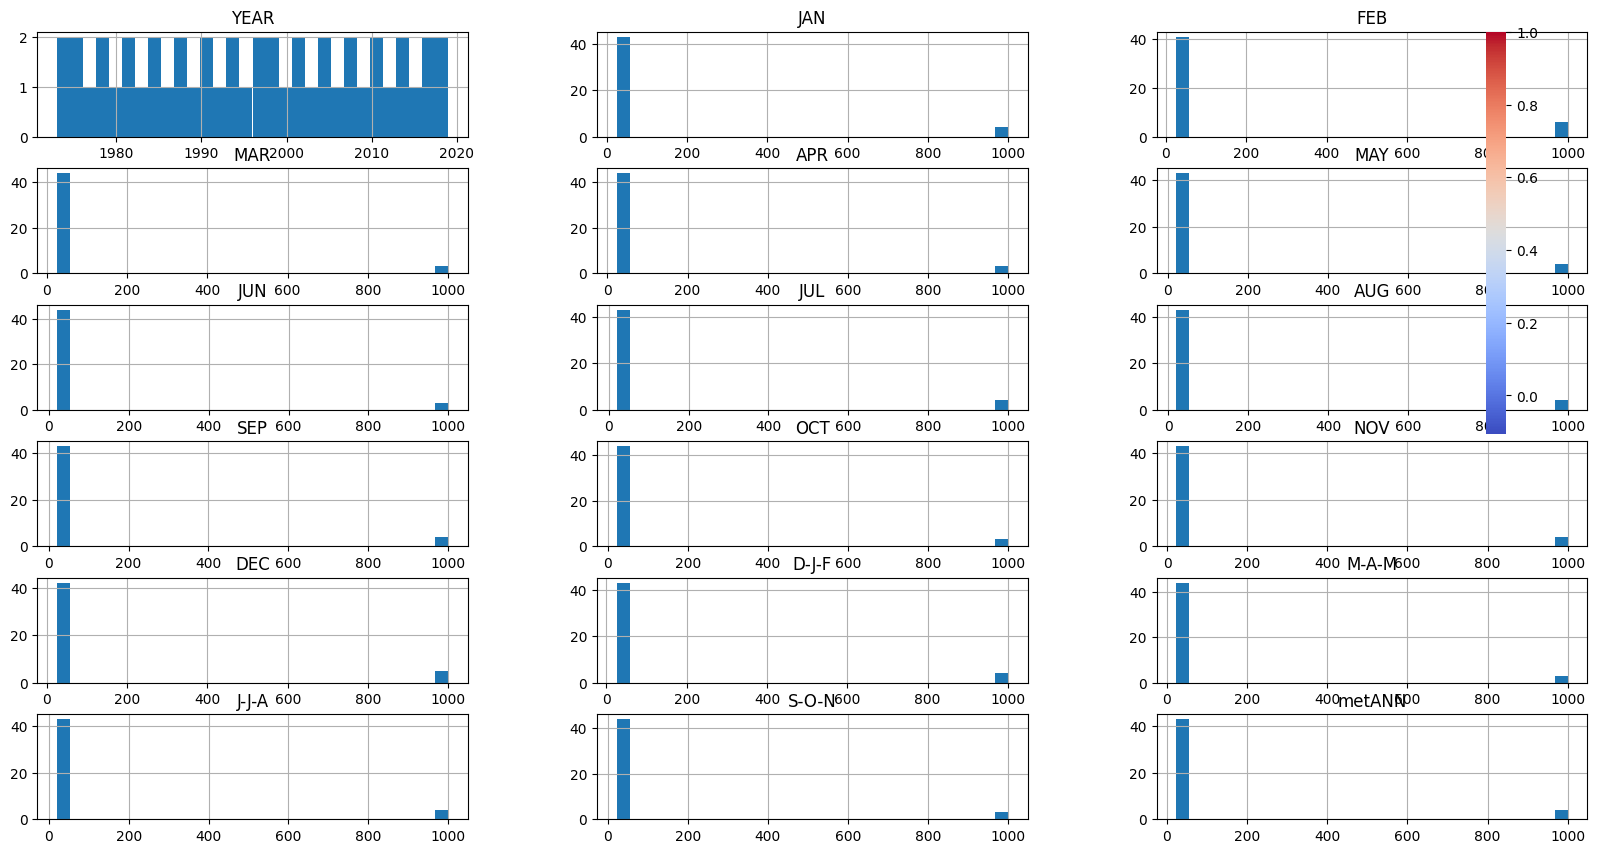


Final feature columns: ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'metANN']

Scaled data shape: (47, 18)

Scaled data sample:
       YEAR       JAN       FEB       MAR       APR       MAY       JUN  \
0 -1.695582 -0.303460 -0.381361 -0.264748 -0.255370 -0.306407 -0.256186   
1 -1.621862 -0.307329 -0.383857 -0.261133 -0.266072 -0.305160 -0.264800   
2 -1.548141 -0.312524 -0.384597 -0.261680 -0.270772 -0.310258 -0.265636   
3 -1.474420 -0.304381 -0.386816 -0.265378 -0.261665 -0.307911 -0.262793   
4 -1.400699 -0.305671 -0.379697 -0.259788 -0.264897 -0.306664 -0.258820   

        JUL       AUG       SEP       OCT       NOV       DEC     D-J-F  \
0 -0.301516 -0.308281 -0.308433 -0.266581 -0.311532 -0.346388 -0.303511   
1 -0.304958 -0.305423 -0.303117 -0.265156 -0.306203 -0.350751 -0.306790   
2 -0.310524 -0.301135 -0.304987 -0.265785 -0.307673 -0.344123 -0.310400   
3 -0.308839 -0.307841 -0.309130 -0.2

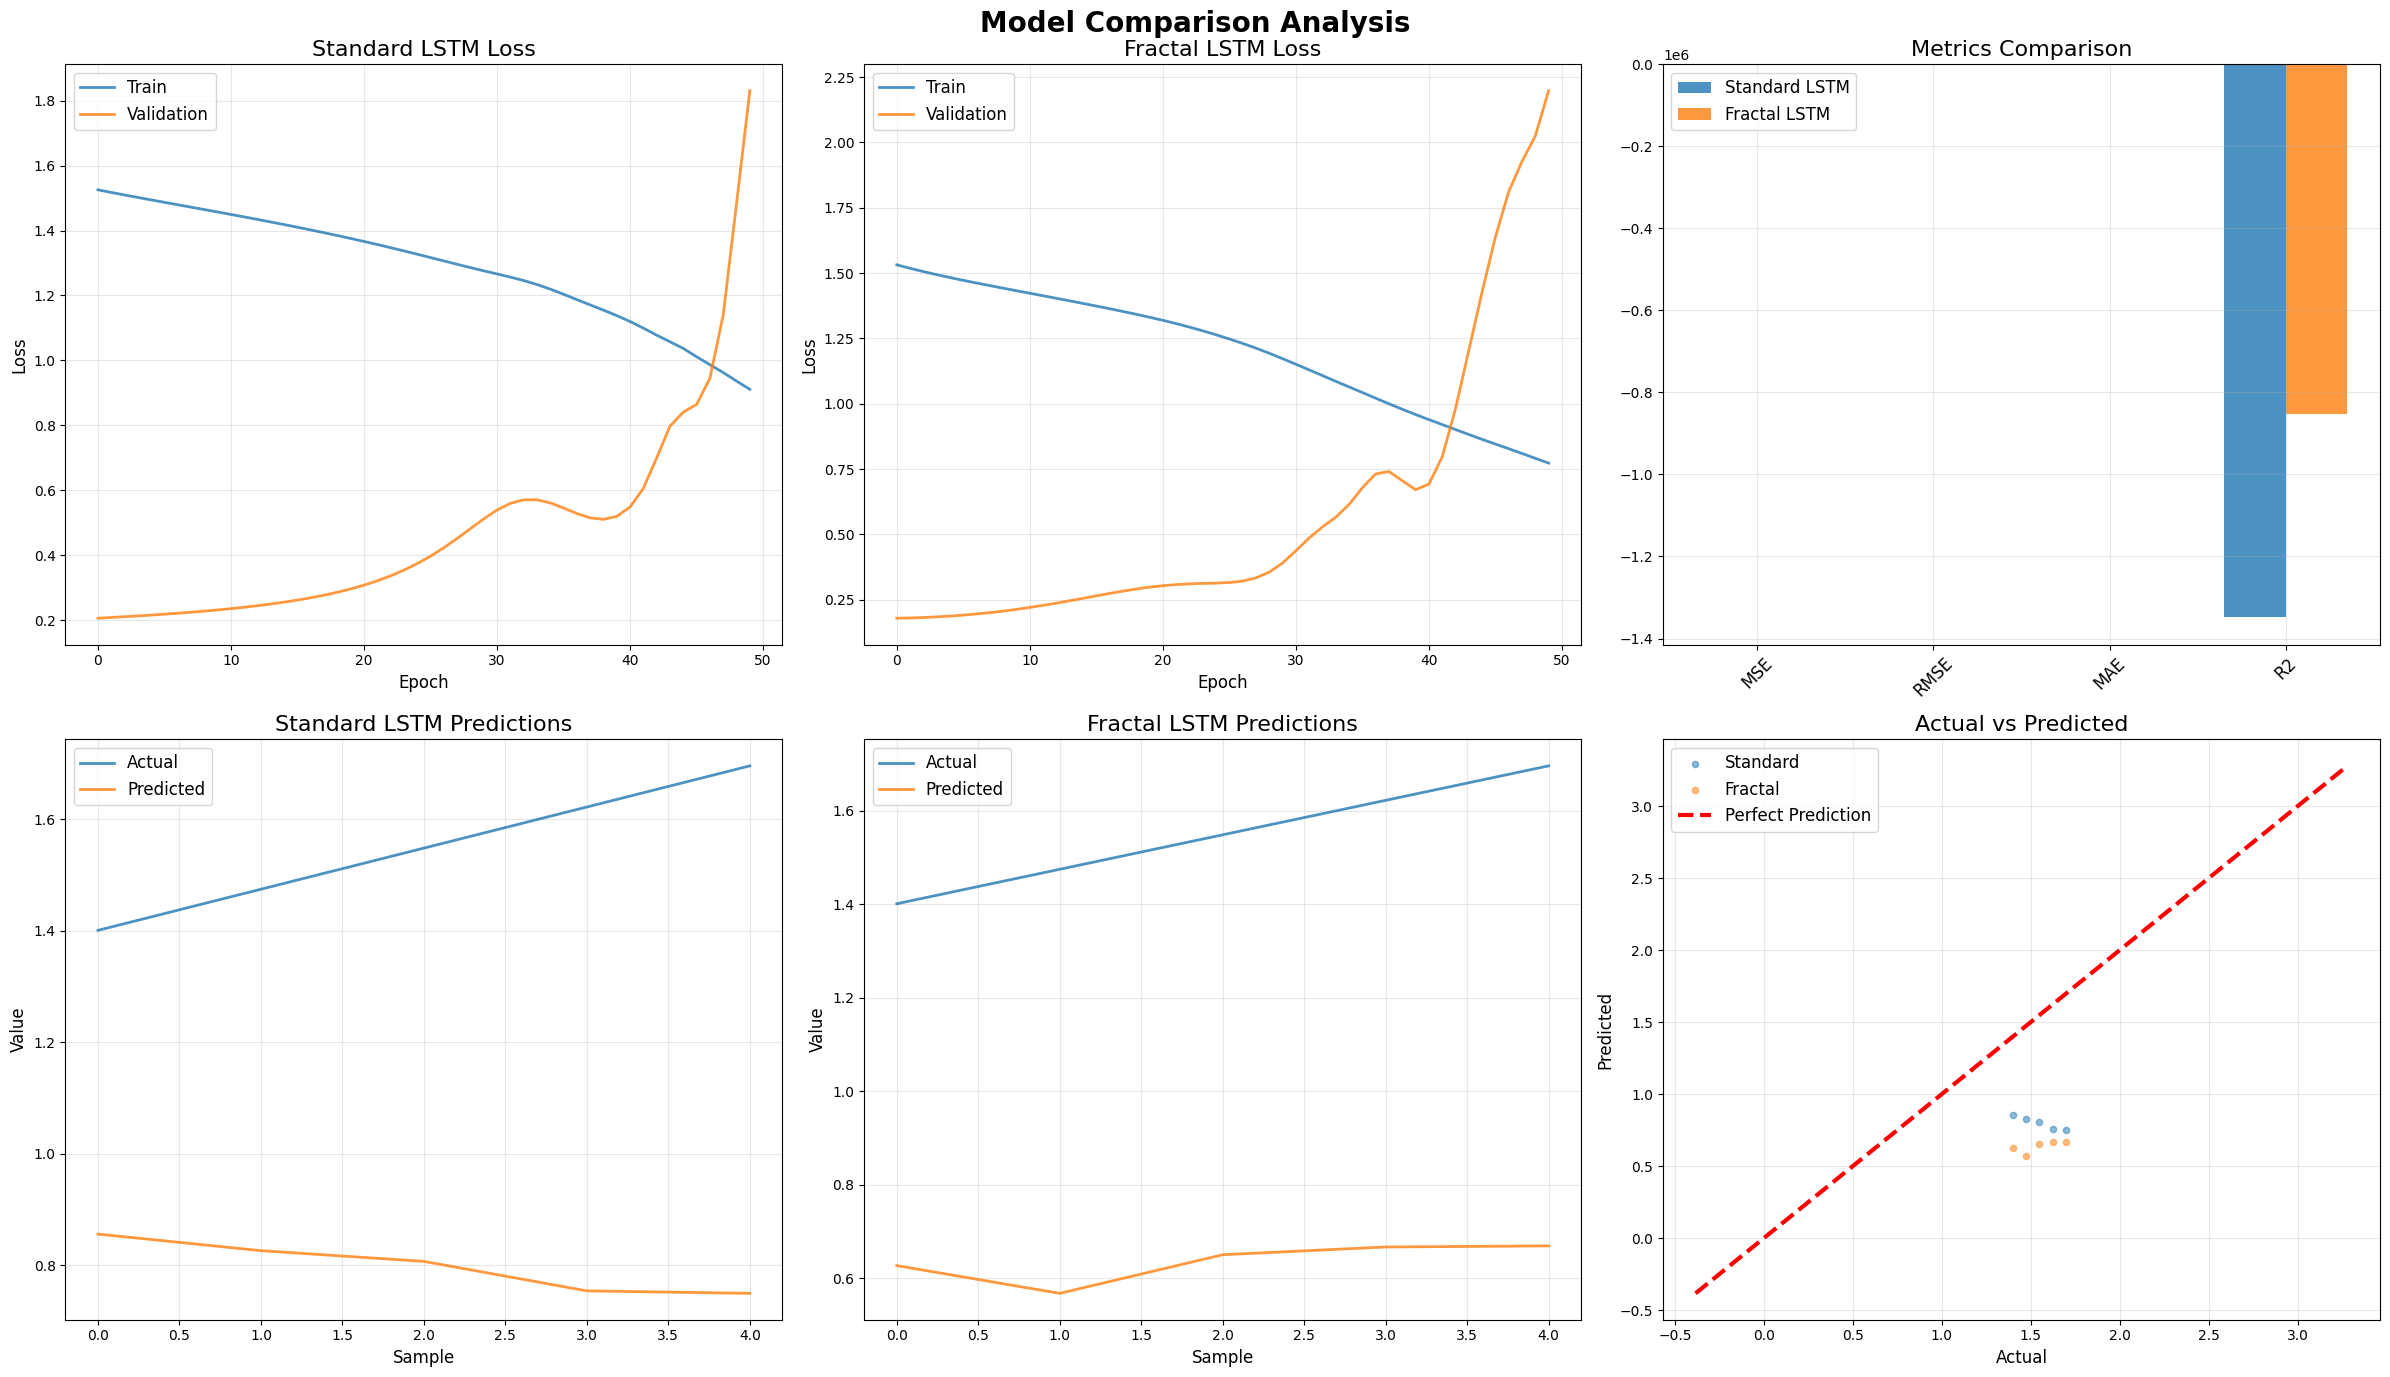


Analysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'

GPU Memory Used: 0.03 GB


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '/kaggle/input/temperature-timeseries-for-some-brazilian-cities/station_rio.csv'
SEQUENCE_LENGTH = 24
HIDDEN_SIZE = 63
FRACTAL_LEVELS = 3
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("FRACTAL MEMORY LSTM vs STANDARD LSTM BENCHMARK")
print("="*80)
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

df = pd.read_csv(FILE_PATH)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Dataset Analysis', fontsize=20, fontweight='bold')

if len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=30, ax=axes[0,0], layout=(len(numeric_cols)//3+1, 3))
    axes[0,0].set_title('Distributions', fontsize=14)
    
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0,1], fmt='.2f', annot_kws={'size': 10})
axes[0,1].set_title('Correlation Matrix', fontsize=14)

if len(numeric_cols) >= 2:
    axes[1,0].plot(df[numeric_cols[0]].values[:200], linewidth=2)
    axes[1,0].set_title(f'{numeric_cols[0]} Time Series (First 200)', fontsize=14)
    axes[1,0].set_xlabel('Time', fontsize=12)
    axes[1,0].set_ylabel('Value', fontsize=12)
    axes[1,0].grid(True, alpha=0.3)

if len(df) > 0:
    axes[1,1].boxplot([df[col].dropna() for col in numeric_cols[:5]], labels=numeric_cols[:5])
    axes[1,1].set_title('Boxplots', fontsize=14)
    axes[1,1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1,1].tick_params(axis='y', labelsize=10)
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

df_processed = df.copy()

for col in categorical_cols:
    if df_processed[col].nunique() < 50:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        print(f"\nEncoded {col}: {df_processed[col].nunique()} classes")

df_processed = df_processed.fillna(df_processed.mean())

feature_cols = [col for col in df_processed.columns if col in numeric_cols or col in categorical_cols]
print(f"\nFinal feature columns: {feature_cols}")

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed[feature_cols]),
    columns=feature_cols
)

print(f"\nScaled data shape: {df_scaled.shape}")
print("\nScaled data sample:")
print(df_scaled.head())

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

data_array = df_scaled.values
X, y = create_sequences(data_array, SEQUENCE_LENGTH)

print(f"\nSequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class FractalMemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_levels):
        super(FractalMemoryCell, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.level_size = hidden_size // num_levels
        
        self.input_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.forget_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.cell_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        self.output_gates = nn.ModuleList([
            nn.Linear(input_size + hidden_size // num_levels, hidden_size // num_levels) 
            for _ in range(num_levels)
        ])
        
        self.level_interactions = nn.ModuleList([
            nn.Linear((hidden_size // num_levels) * 2, hidden_size // num_levels) 
            for _ in range(num_levels - 1)
        ])
    
    def forward(self, x, hidden_states, cell_states):
        new_hidden_states = []
        new_cell_states = []
        level_size = self.hidden_size // self.num_levels
        
        for level in range(self.num_levels):
            h_prev = hidden_states[level]
            c_prev = cell_states[level]
            
            combined = torch.cat([x, h_prev], dim=1)
            
            i_t = torch.sigmoid(self.input_gates[level](combined))
            f_t = torch.sigmoid(self.forget_gates[level](combined))
            c_tilde = torch.tanh(self.cell_gates[level](combined))
            o_t = torch.sigmoid(self.output_gates[level](combined))
            
            c_t = f_t * c_prev + i_t * c_tilde
            
            if level > 0:
                interaction = torch.cat([c_t, new_cell_states[level-1]], dim=1)
                c_t = c_t + torch.tanh(self.level_interactions[level-1](interaction))
            
            h_t = o_t * torch.tanh(c_t)
            
            new_hidden_states.append(h_t)
            new_cell_states.append(c_t)
        
        return new_hidden_states, new_cell_states

class FractalMemoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_levels):
        super(FractalMemoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        
        self.fractal_cell = FractalMemoryCell(input_size, hidden_size, num_levels)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        level_size = self.hidden_size // self.num_levels
        
        hidden_states = [torch.zeros(batch_size, level_size, device=x.device) 
                        for _ in range(self.num_levels)]
        cell_states = [torch.zeros(batch_size, level_size, device=x.device) 
                      for _ in range(self.num_levels)]
        
        for t in range(seq_len):
            hidden_states, cell_states = self.fractal_cell(
                x[:, t, :], hidden_states, cell_states
            )
        
        final_hidden = torch.cat(hidden_states, dim=1)
        out = self.fc(final_hidden)
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

standard_lstm = StandardLSTM(input_size, HIDDEN_SIZE, output_size).to(device)
fractal_lstm = FractalMemoryLSTM(input_size, HIDDEN_SIZE, output_size, FRACTAL_LEVELS).to(device)

print(f"\nStandard LSTM parameters: {sum(p.numel() for p in standard_lstm.parameters())}")
print(f"Fractal LSTM parameters: {sum(p.numel() for p in fractal_lstm.parameters())}")

def train_model(model, train_loader, val_loader, epochs, lr, model_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    print(f"\nTraining {model_name}...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return predictions, actuals, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

standard_train_losses, standard_val_losses = train_model(
    standard_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Standard LSTM"
)

fractal_train_losses, fractal_val_losses = train_model(
    fractal_lstm, train_loader, val_loader, EPOCHS, LEARNING_RATE, "Fractal Memory LSTM"
)

standard_preds, standard_actuals, standard_metrics = evaluate_model(standard_lstm, test_loader)
fractal_preds, fractal_actuals, fractal_metrics = evaluate_model(fractal_lstm, test_loader)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

print("\nStandard LSTM Metrics:")
for metric, value in standard_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\nFractal Memory LSTM Metrics:")
for metric, value in fractal_metrics.items():
    print(f"{metric}: {value:.6f}")

print("\n" + "="*80)
print("COMPARISON")
print("="*80)

for metric in standard_metrics.keys():
    std_val = standard_metrics[metric]
    frac_val = fractal_metrics[metric]
    
    if metric == 'R2':
        improvement = ((frac_val - std_val) / abs(std_val)) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val > std_val else "Standard"
    else:
        improvement = ((std_val - frac_val) / std_val) * 100 if std_val != 0 else 0
        better = "Fractal" if frac_val < std_val else "Standard"
    
    print(f"{metric}: {better} LSTM better by {abs(improvement):.2f}%")

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('Model Comparison Analysis', fontsize=20, fontweight='bold')

axes[0,0].plot(standard_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,0].plot(standard_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,0].set_title('Standard LSTM Loss', fontsize=16)
axes[0,0].set_xlabel('Epoch', fontsize=12)
axes[0,0].set_ylabel('Loss', fontsize=12)
axes[0,0].legend(fontsize=12)
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(fractal_train_losses, label='Train', alpha=0.8, linewidth=2)
axes[0,1].plot(fractal_val_losses, label='Validation', alpha=0.8, linewidth=2)
axes[0,1].set_title('Fractal LSTM Loss', fontsize=16)
axes[0,1].set_xlabel('Epoch', fontsize=12)
axes[0,1].set_ylabel('Loss', fontsize=12)
axes[0,1].legend(fontsize=12)
axes[0,1].grid(True, alpha=0.3)

metrics_names = list(standard_metrics.keys())
standard_values = [standard_metrics[m] for m in metrics_names]
fractal_values = [fractal_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[0,2].bar(x - width/2, standard_values, width, label='Standard LSTM', alpha=0.8)
axes[0,2].bar(x + width/2, fractal_values, width, label='Fractal LSTM', alpha=0.8)
axes[0,2].set_title('Metrics Comparison', fontsize=16)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(metrics_names, rotation=45, fontsize=12)
axes[0,2].legend(fontsize=12)
axes[0,2].grid(True, alpha=0.3)

sample_size = min(200, len(standard_actuals))
axes[1,0].plot(standard_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,0].plot(standard_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,0].set_title('Standard LSTM Predictions', fontsize=16)
axes[1,0].set_xlabel('Sample', fontsize=12)
axes[1,0].set_ylabel('Value', fontsize=12)
axes[1,0].legend(fontsize=12)
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(fractal_actuals[:sample_size, 0], label='Actual', alpha=0.8, linewidth=2)
axes[1,1].plot(fractal_preds[:sample_size, 0], label='Predicted', alpha=0.8, linewidth=2)
axes[1,1].set_title('Fractal LSTM Predictions', fontsize=16)
axes[1,1].set_xlabel('Sample', fontsize=12)
axes[1,1].set_ylabel('Value', fontsize=12)
axes[1,1].legend(fontsize=12)
axes[1,1].grid(True, alpha=0.3)

axes[1,2].scatter(standard_actuals[:, 0], standard_preds[:, 0], alpha=0.5, label='Standard', s=20)
axes[1,2].scatter(fractal_actuals[:, 0], fractal_preds[:, 0], alpha=0.5, label='Fractal', s=20)
axes[1,2].plot([standard_actuals.min(), standard_actuals.max()], 
               [standard_actuals.min(), standard_actuals.max()], 
               'r--', lw=3, label='Perfect Prediction')
axes[1,2].set_title('Actual vs Predicted', fontsize=16)
axes[1,2].set_xlabel('Actual', fontsize=12)
axes[1,2].set_ylabel('Predicted', fontsize=12)
axes[1,2].legend(fontsize=12)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete. Results saved to 'dataset_analysis.png' and 'model_comparison.png'")

if torch.cuda.is_available():
    print(f"\nGPU Memory Used: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")
    torch.cuda.empty_cache()